# Predicción de la reserva mensual en embalses

## 1. Introducción

Disponer de una secuencia o serie temporal de datos con una cadencia constante permite la aplicación de diferentes técnicas estadísticas que son capaces de extraer información sobre la estructura interna de dicha serie. Conociendo dicha estructura es posible hacer una estimación de los datos que continuarían la serie. Como ocurre con toda estimación, hay un error asociado y una incertidumbre que aumenta a medida que nos alejeamos del último dato de la serie. Por tanto la cuestión estriba en determinar un modelo estadístico que nos permita hacer predicciones con un grado de error que considerememos aceptable.

En la Red de Información Ambiental de Andalucía están disponibles los datos diarios de reserva de los principales embalses en su territorio desde 2009 hasta la actualidad. Estos datos pueden ser descargados en formato geopackage desde [aquí](https://descargasrediam.cica.es/repo/s/RUR?path=%2F04_RECURSOS_NATURALES%2F04_AGUAS%2F01_SUPERFICIALES%2F00_SUPERFICIALES%2FEmbalses_al_dia%2FInfGeografica%2FInfVectorial%2Fgpkg).

Como ejemplo de aplicación de estos modelos de predicción se van a emplear los datos disponibles de reserva del embalse de Tranco de Beas en Jaén. Dado la que la evolución de la reserva suele ser muy lenta de un día para otro, tiene más sentido emplear la reserva mensual donde queda más patente su evolución.

Los pasos a seguir son los siguientes:

1. **Lectura de datos**: Se crea una tabla de datos a partir de los datos recogidos de nuestra fuente.
2. **Análisis exploratorio**: Se ve como se distribuyen los datos de la serie, se analiza la estacionariedad de la serie y se calculan sus parámetros estadísticos.
3. **Ingenieria de datos**: Se detectan y se tratan e resolver los huecos y los datos anómalos existentes. 
4. **Ingeniería de características**: A raíz de los resultados del análisis exploratorio se aplican las transformaciones a los datos que se consideren oportunas.
5. **Cálculo de los modelos de predicción**.
6. **Efectividad de los modelos**

## 2. Carga de librerías y lectura de datos

In [98]:
options(repr.plot.width = 12, repr.plot.high = 6)
library(xts)
library(sf)
library(forecast)


Los datos necesarios son descargados desde [Descargas Rediam](https://descargasrediam.cica.es/repo/s/RUR) dentro del proyecto **Embalses al día**. Esta base de datos es actualizada de diariamente.

En este caso necesitamos descargar una base de datos en formato geopackage. El mecanismo descarga empleado es tal que el archivo descargado está comprimido en formato zip que luego es necesario descomprimir.

In [15]:
# Se monta la ruta de descarga desde la fuente de datos (Descargas Rediam)
url_base <- 'https://descargasrediam.cica.es/repo/s/RUR/download?path='
project_folder <- '/04_RECURSOS_NATURALES/04_AGUAS/01_SUPERFICIALES/00_SUPERFICIALES/Embalses_al_dia/'
file_folder <- 'InfGeografica/InfVectorial/gpkg'
url <- paste0(url_base,
              gsub("/", "%2F", paste0(project_folder, file_folder)),
              '&file=embdia.gpkg')

# Se ejecuta la descarga
download.file(url, 'data/embdia.zip',quiet=TRUE, mode="wb")

# Se descomprime el archivo descargado en la carpeta "data"
unzip('data/embdia.zip',exdir = 'data')


Una vez descargada la base de datos, extraemos los datos de la tabla "datos_reserva" que contiene el histórico de reservas diarias desde 2009 hasta la fecha actual.

In [4]:
# lectura de la tabla de datos diarios de reserva
data <- sf::st_read('data/gpkg/embdia.gpkg', layer ='datos_reserva')
head(data)

Reading layer `datos_reserva' from data source `H:\cloud\OneDrive\OneDrive - UNED\ws_datascience\projects\forecasting_series_temporales_arima_reserva_embalses\data\gpkg\embdia.gpkg' using driver `GPKG'


Warning message:
"no simple feature geometries present: returning a data.frame or tbl_df"


,cod_est,fecha,reserva
,<chr>,<date>,<dbl>
1,E01,2009-01-02,166.00
2,E02,2009-01-02,6.39
3,E03,2009-01-02,12.35
4,E04,2009-01-02,24.90
5,E05,2009-01-02,27.47
6,E06,2009-01-02,235.84


In [5]:
# Se seleccionan los datos del embalse Tranco de Beas, correspondiente al codigo de estación 'E01'
datemb <- subset(data, cod_est == 'E01')
head(datemb)
tail(datemb)

,cod_est,fecha,reserva
,<chr>,<date>,<dbl>
1,E01,2009-01-02,166.00
71,E01,2009-01-09,174.31
139,E01,2009-01-19,180.28
203,E01,2009-01-20,181.67
332,E01,2009-01-23,190.05
397,E01,2009-01-24,202.14


,cod_est,fecha,reserva
,<chr>,<date>,<dbl>
306091,E01,2021-03-26,306.41
306164,E01,2021-03-27,306.23
306237,E01,2021-03-28,305.92
306310,E01,2021-03-29,306.26
306383,E01,2021-03-30,306.44
306456,E01,2021-03-31,306.54


## 3. Ingenería de datos

En este apartado se van analizar los datos diarios descargados en busca de datos anómalos y de datos faltantes. Una vez se hayan corregido estos aspecto, se creará la serie de datos mensuales.

### 3.1 Eliminación de datos anómalos

En primer lugar examinamos la gráfica de los datos de reservas diarias descargadso del embalse Tranco de Beas.

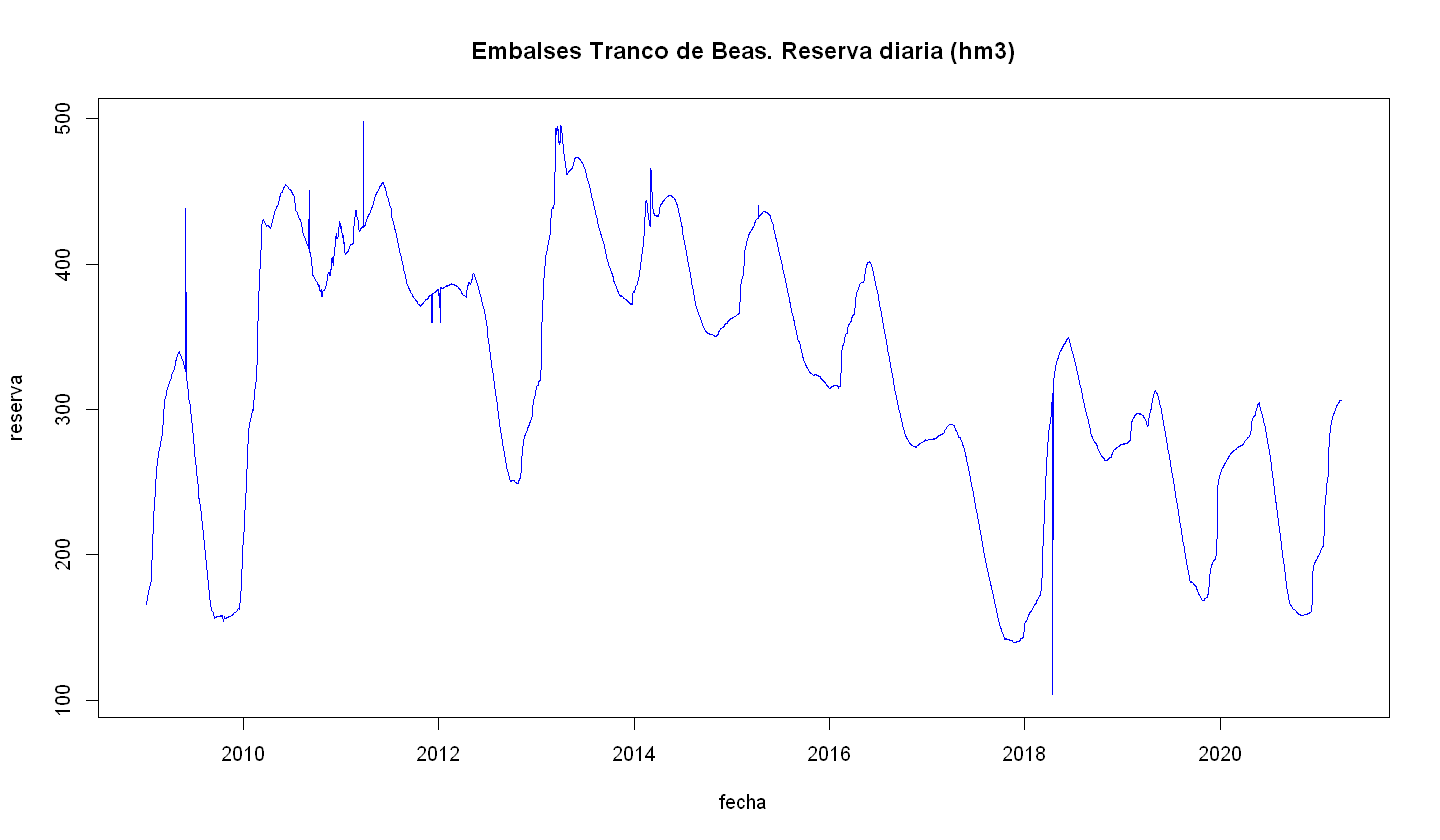

In [6]:
plot(datemb[,2:3],type = 'l',col='blue',main ='Embalses Tranco de Beas. Reserva diaria (hm3)')

Se observa que hay días en donde el datos de reserva no se ajusta a lo esperado. Estos datos son detectados visualmente y eliminados.

Para facilitar este proceso la serie de datos se pasa a una estructura de datos xts, que facilita la gestión y consulta de series temporales.

           reserva
2009-01-02  166.00
2009-01-09  174.31
2009-01-19  180.28
2009-01-20  181.67
2009-01-23  190.05
2009-01-24  202.14

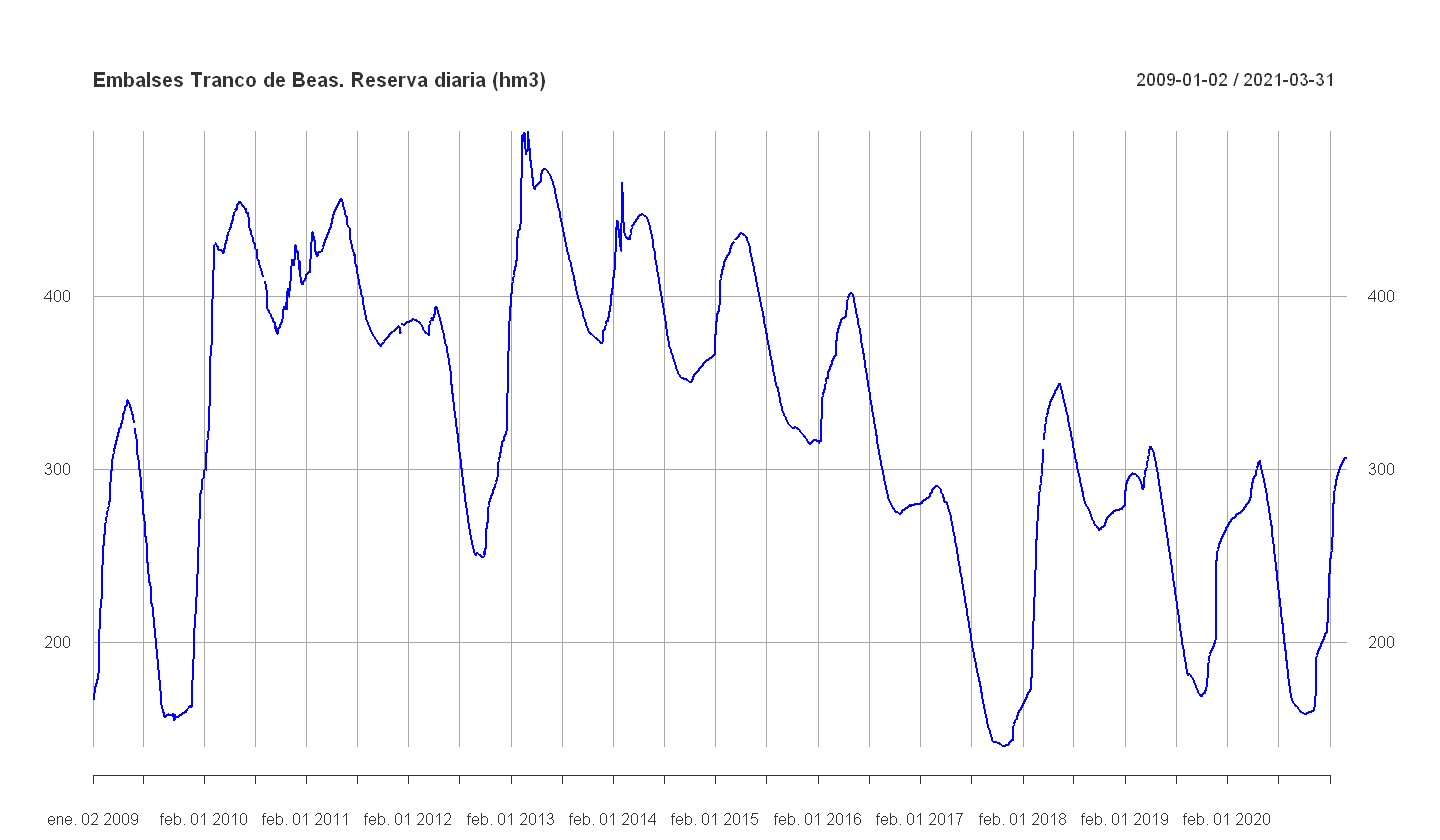

In [7]:
# Transformación a xts
resdiaria_xts <- xts(datemb$reserva, order.by = datemb$fecha)
colnames(resdiaria_xts) <- 'reserva'
head(resdiaria_xts)

# Eliminación de anomalías
resdiaria_xts['2009-05-30'] <-NA
resdiaria_xts['2010-09-03'] <-NA
resdiaria_xts['2011-03-26'] <-NA
resdiaria_xts['2011-12-06'] <-NA
resdiaria_xts['2011-12-07'] <-NA
resdiaria_xts['2012-01-06'] <-NA
resdiaria_xts['2015-04-10'] <-NA
resdiaria_xts['2018-04-16'] <-NA

plot(resdiaria_xts, col='blue', main = 'Embalses Tranco de Beas. Reserva diaria (hm3)')

Una forma interesante de representar estos datos es en forma polar, donde la reserva viene dada por la distancia de cada punto al origen y el tiempo viene dado por el ángulo barrido.

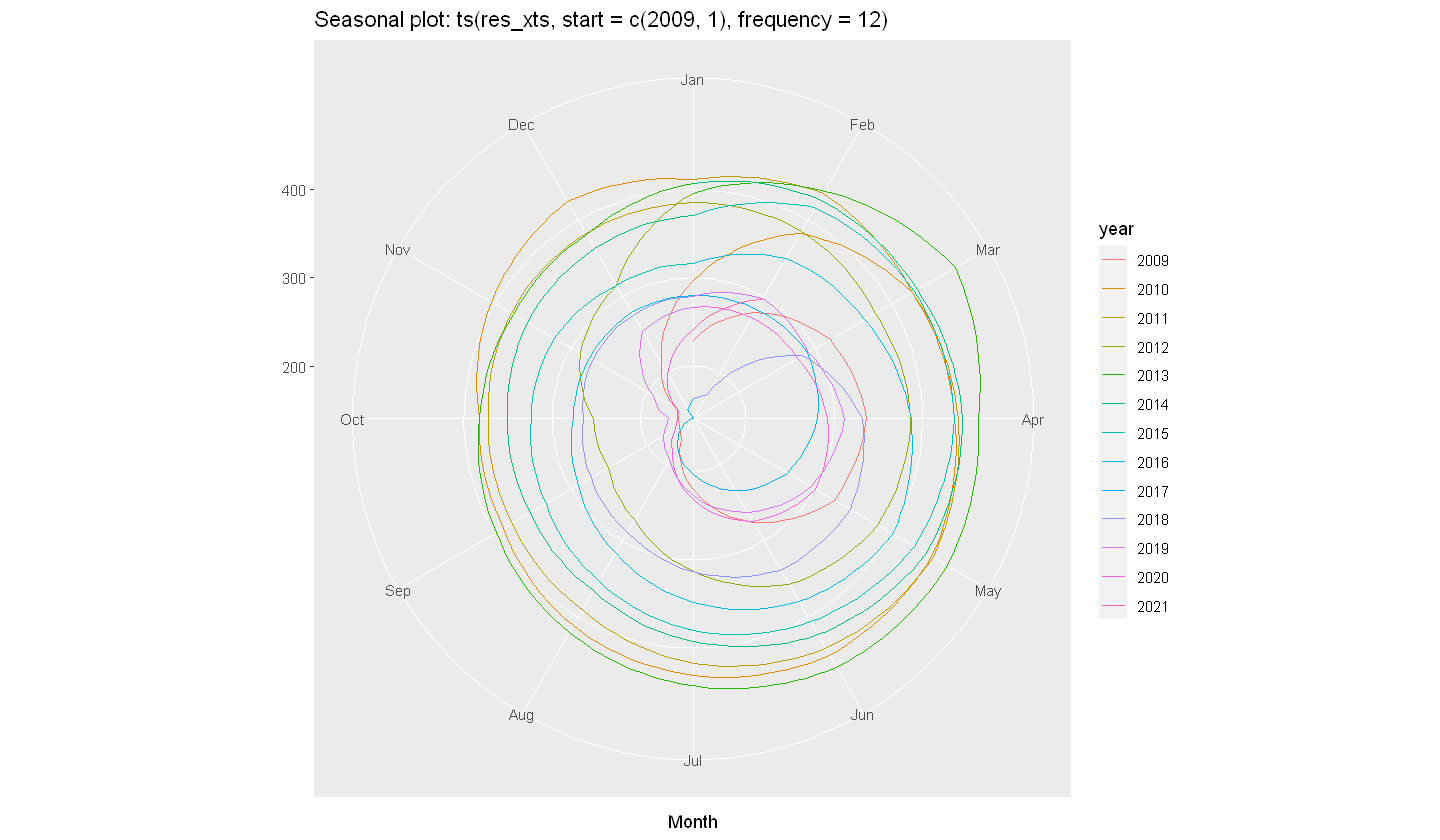

In [99]:
ggseasonplot(ts(res_xts, start=c(2009,1), frequency=12), polar="TRUE")

## 3.2 Imputación de datos faltantes

A continuación se van a detectar las fechas en donde no existe ningún dato imputado. Una vez localizados se genera una serie temporal con los huecos correspondientes, que podrán ser visualizados posteriormente.

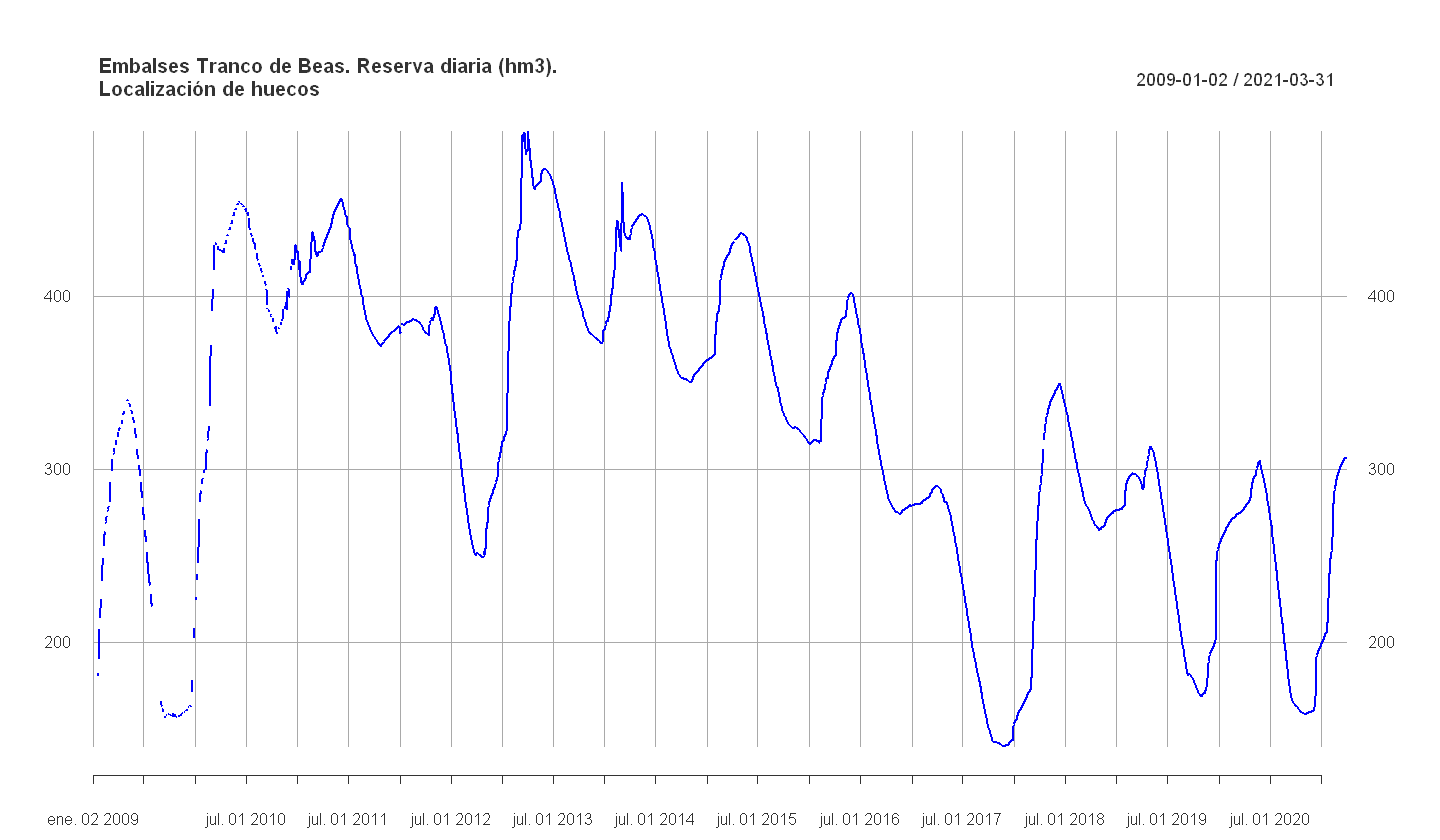

In [8]:
# Se crea una serie de datos de soporte que contenga todos los dias entre el primer y el último deatos de la serie.
seq_daily <- seq(from=first(index(resdiaria_xts)),
                 to = last(index(resdiaria_xts)),
                 by='days')
dummy_xts <- xts(rep(0,length(seq_daily)), order.by = seq_daily)

# Se combinan como columnas la serie de soporte y la original para general los huecos.
resdiaria01_xts <- cbind(dummy_xts, resdiaria_xts)[,2]
plot(resdiaria01_xts,
     col='blue',
     main = ' Embalses Tranco de Beas. Reserva diaria (hm3).\n Localización de huecos')

Como se observa la falta de datos se localiza, salvo algún valor esporádico, en los años 2009 y 2010. No obstante es posible interpolar los datos en estos huecos. Hay una amplia variedad de métodos para hacer esta interpolación. En este caso se va a usar la [interpolación por splines](https://es.wikipedia.org/wiki/Spline)

In [9]:
resdiaria_int <- na.spline(resdiaria01_xts)
colnames(resdiaria_int) <- 'resint'
resdiaria02_xts <- cbind(resdiaria01_xts,resdiaria_int)
head(resdiaria02_xts)
resdiaria03_xts <- resdiaria02_xts$resint
colnames(resdiaria03_xts) <- 'reserva'

           reserva   resint
2009-01-02     166 166.0000
2009-01-03      NA 168.0734
2009-01-04      NA 169.7921
2009-01-05      NA 171.1916
2009-01-06      NA 172.3076
2009-01-07      NA 173.1755

La gráfica de la serie temporal con los datos interpolados es la siguiente.

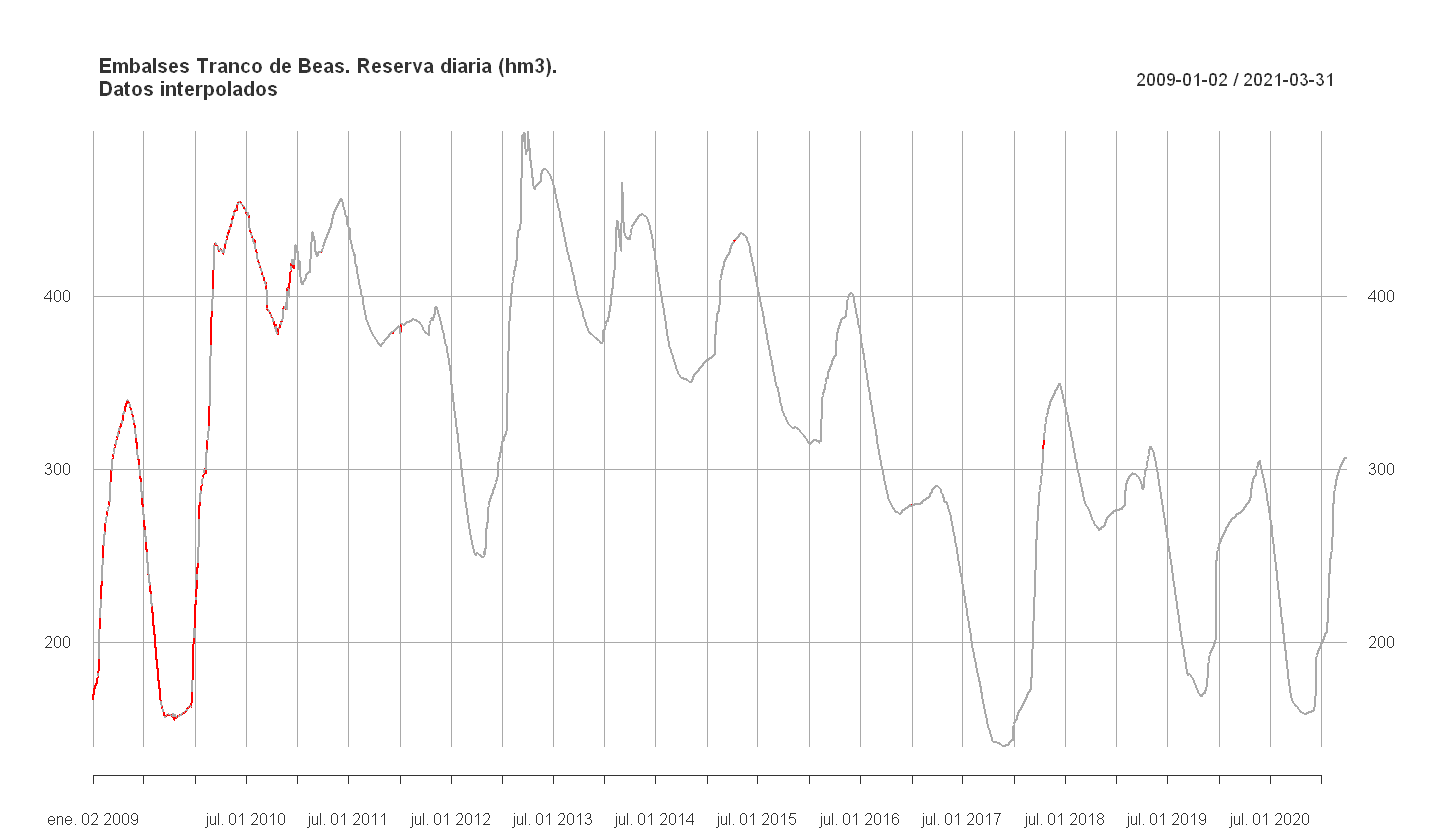

In [10]:
plot(resdiaria02_xts, screens = factor(1, 1),
     col=c('dark grey','red'),
     main = ' Embalses Tranco de Beas. Reserva diaria (hm3).\n Datos interpolados')

### 3.3 Creación de la serie de datos mensuales

Esta serie es generada a partir de la serie de datos diarios de manera que los datos del último día de cada mes será el valor de reserva mensual asignado. Este proceso puede hacerse por diferentes vías, pero el disponer nuestros datos en un objeto xts nos facilita una via rápida.

In [11]:
res_xts <- apply.monthly(resdiaria03_xts, last)
res_xts <- res_xts[1:(nrow(res_xts)-1),]
head(res_xts)
tail(res_xts)

            reserva
2009-01-31 229.2731
2009-02-28 279.5406
2009-03-31 319.4200
2009-04-30 336.4608
2009-05-31 324.6378
2009-06-30 275.8100

           reserva
2020-09-30  162.76
2020-10-31  158.43
2020-11-30  159.97
2020-12-31  198.19
2021-01-31  241.31
2021-02-28  296.35

## 4. Análisis exploratorio

En este apartado se analizan las carácterísticas básicas de la serie de datos y su distribución.

     Index               reserva     
 Min.   :2009-01-31   Min.   :140.1  
 1st Qu.:2012-02-07   1st Qu.:272.4  
 Median :2015-02-14   Median :324.2  
 Mean   :2015-02-14   Mean   :323.2  
 3rd Qu.:2018-02-21   3rd Qu.:391.6  
 Max.   :2021-02-28   Max.   :483.4  

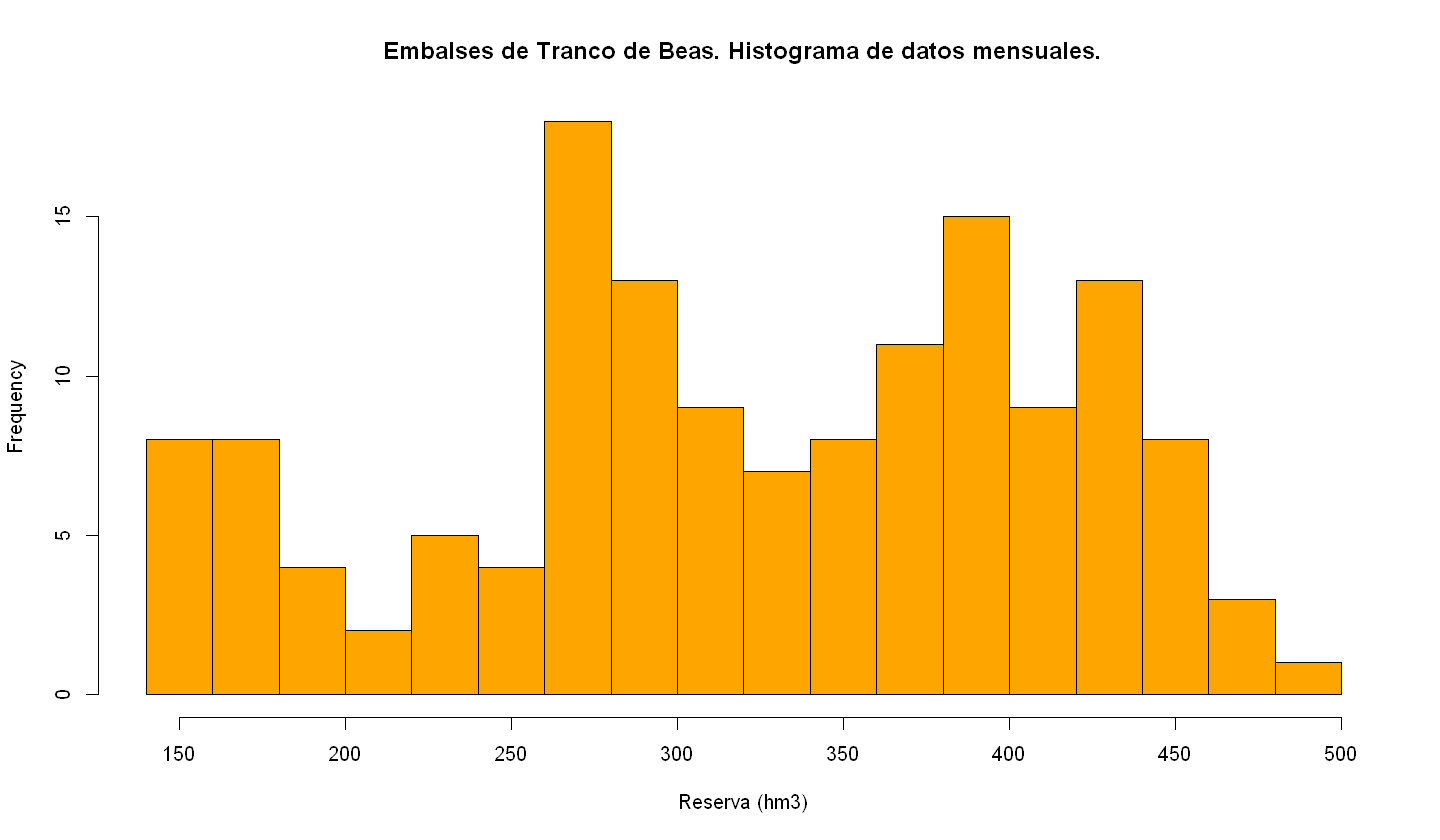

In [12]:
summary(res_xts)
hist(res_xts, n=20, col='orange',
     main ='Embalses de Tranco de Beas. Histograma de datos mensuales.',
     xlab='Reserva (hm3)')

Para los siguiente análisis, las librerías empleadas requieren volver a trasformar la serie anterior a una estructura de serie temporal tipo ts que permite también mostrar una serie de datos mensuales de forma más compacta.

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2009,229.2731,279.5406,319.4200,336.4608,324.6378,275.8100,220.6600,166.8867,157.7400,156.9386,160.1100,211.5118
2010,296.4729,383.0905,426.7000,436.6800,452.3600,449.4300,431.1043,411.2700,388.1300,382.2663,404.0000,424.7400
2011,411.0000,434.6200,426.8100,440.3700,454.4500,440.6000,416.9800,390.1200,376.8900,372.2700,378.3300,382.6700
2012,385.0800,385.6100,379.0800,386.8900,381.7700,356.9100,312.7100,272.4100,250.9100,253.1200,287.7100,314.5300
2013,396.0500,438.0700,483.4400,463.1100,473.3700,465.5300,442.9000,419.9600,397.7500,381.7700,375.6600,380.8700
2014,407.0900,426.9100,433.2900,445.5800,445.2400,423.0200,392.0500,365.4300,353.1000,350.3100,356.8200,362.7500
2015,370.3400,416.3200,429.6500,436.2900,429.3900,405.9800,379.9000,352.7800,332.5300,323.8500,321.6100,314.7400
2016,316.1600,350.0000,365.0200,387.1500,401.6300,379.6900,347.8500,315.7300,290.1300,275.9400,275.9500,278.8707
2017,279.7900,283.2600,289.8800,281.0000,263.0200,234.4600,203.1300,175.7500,151.1100,142.1400,140.1300,152.2500
2018,163.3900,172.4000,283.1300,332.2400,345.5300,338.0000,313.6800,288.2600,273.6800,264.8500,272.0900,275.9600


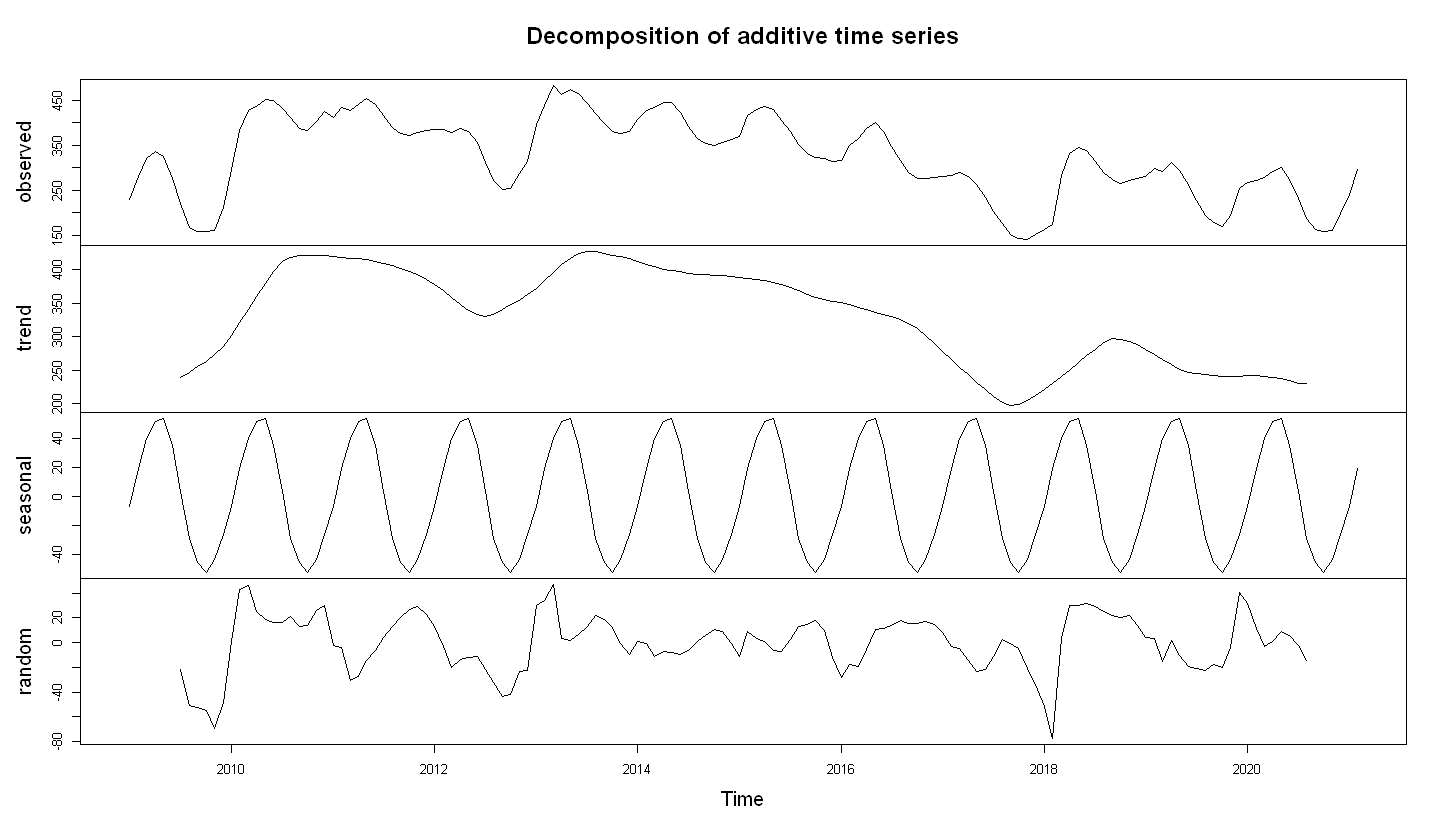

In [59]:
rests00 <- ts(res_xts, start = c(2009,1),frequency = 12)
rests00
rests00.decomp <- decompose(rests00)
plot(rests00.decomp)

Se observa que la componente estacional tienen un escaso peso en relación a la componente de tendencia. Se observa que hay una clara tendencia decreciente desde el año 2013.

Por otro lado, para hacer posteriomente predicciones, es relevante conocer el grado de autocorrelación de la serie ya permite determinar si la serie es estacionaria o no. 

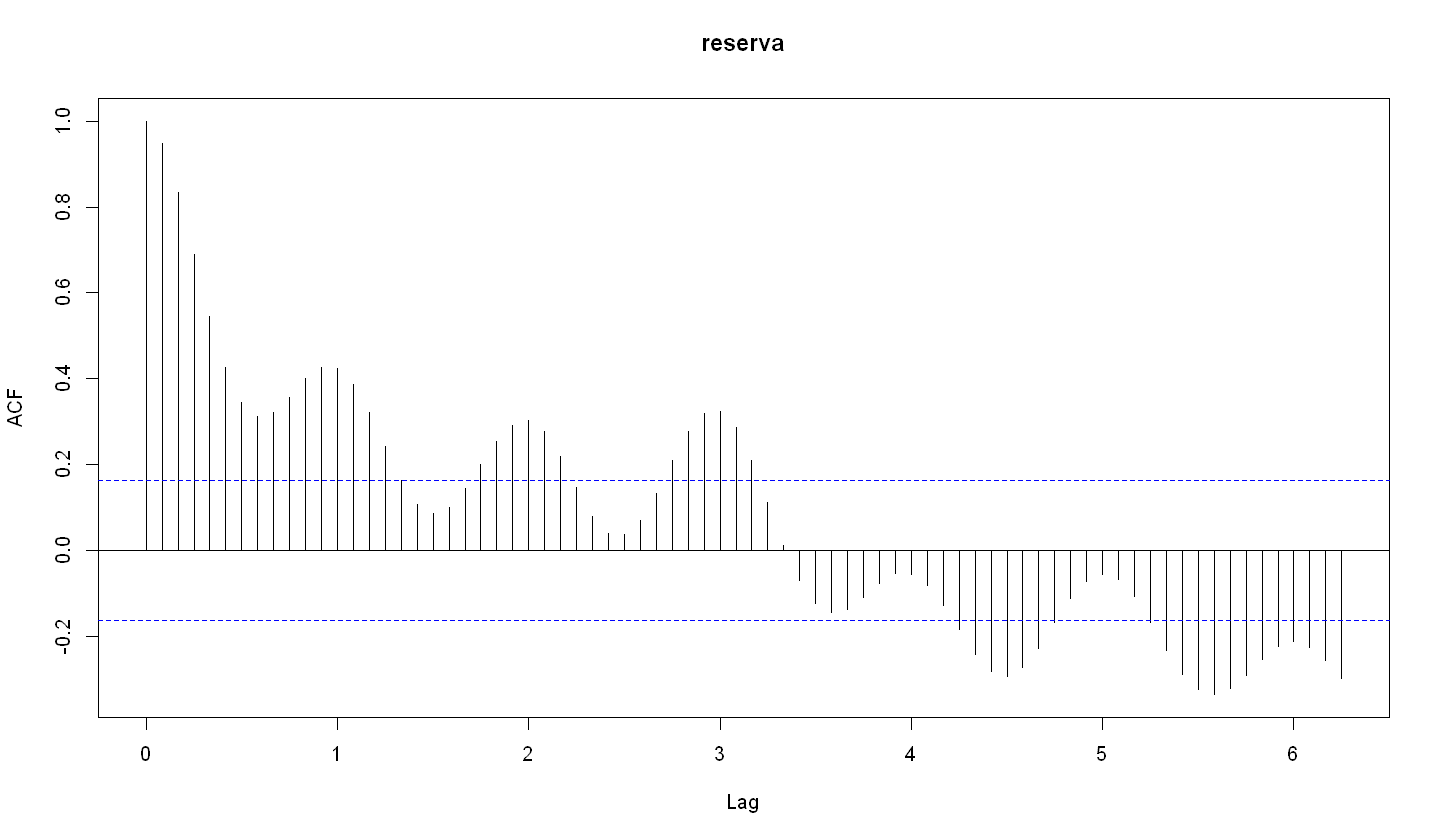

In [32]:
# Vemos si existe autocorrelaciones en los datos
acf(rests00,lag.max=75)

Se observa que existe una correlación marcada.Por tanto la serie a priori parace no ser estacionaria. Esta cuestión se analizará con mas detalle posteriormente.

Los lags en el eje x de la gráfica se refieren a unidades relativas de tiempo no a número de observaciones. En este caso los datos son mensuales por lo que, como se observa, en un año habrá 12 mediciones. A efectos esto se traduce en que el los lags están expresados en años.

## 5. Datos de entrenamiento y datos test

Para comprobar la efectividad de los modelos de predicción que se van a desarrollar se a tomar como serie de entrenamiento la comprendidad entre 2009 y 2019, dejando el año 2020 como serie de comprobación del ajuste de los modelos.

In [33]:
# Serie de entrenamiento
rests <- window(rests00, c(2009,1),c(2019,12))

# Serie para evaluar el ajuste 
rests.check <- window(rests00, c(2020,1),c(2020,12))

# 6 - Análisis mediante suavizado exponencial

https://en.wikipedia.org/wiki/Exponential_smoothing

En el siguiente ejemplo se aplica el método de Holt-Winters que consiste concretamente en un triple alisado exponencial:

* Primer alisado: Incluye el efecto del dato previo de la serie.
* Segundo aliasado: Incluye el efecto de la tendencia de serie.
* Tercer alisado: Incluye el efecto de la estacionalidad de la serie.

Esto deriva en que es necesario, al aplicar este método, determinar tres parámetros a partir de los datos de la series (alfa, beta y gamma)

In [34]:
# Se aplica el alisado exponencial de HoltWinters
(rests.hw <- HoltWinters(rests))

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = rests)

Smoothing parameters:
 alpha: 0.818106
 beta : 1
 gamma: 0.9666872

Coefficients:
           [,1]
a    339.375742
b     22.136813
s1   -34.675332
s2    46.887677
s3   133.456477
s4   162.292106
s5   123.069810
s6    66.123325
s7     6.169208
s8   -52.356206
s9  -102.981348
s10 -137.176009
s11 -124.565372
s12  -84.655116

In [35]:
# Vemos algunos de los valores ajustados.
head(rests.hw$fitted)

,xhat,level,trend,season
Jan 2010,231.0886,209.6223,14.74264,6.723747
Feb 2010,420.4802,277.8562,68.23391,74.390154
Mar 2010,451.3639,315.5013,37.64513,98.217447
Apr 2010,439.6454,332.9688,17.46746,89.209209
May 2010,448.3901,348.0102,15.04142,85.338470
Jun 2010,447.9505,366.2994,18.28924,63.361880


In [36]:
# Suma total del error cuadratico
rests.hw$SSE

[1] 109363.9

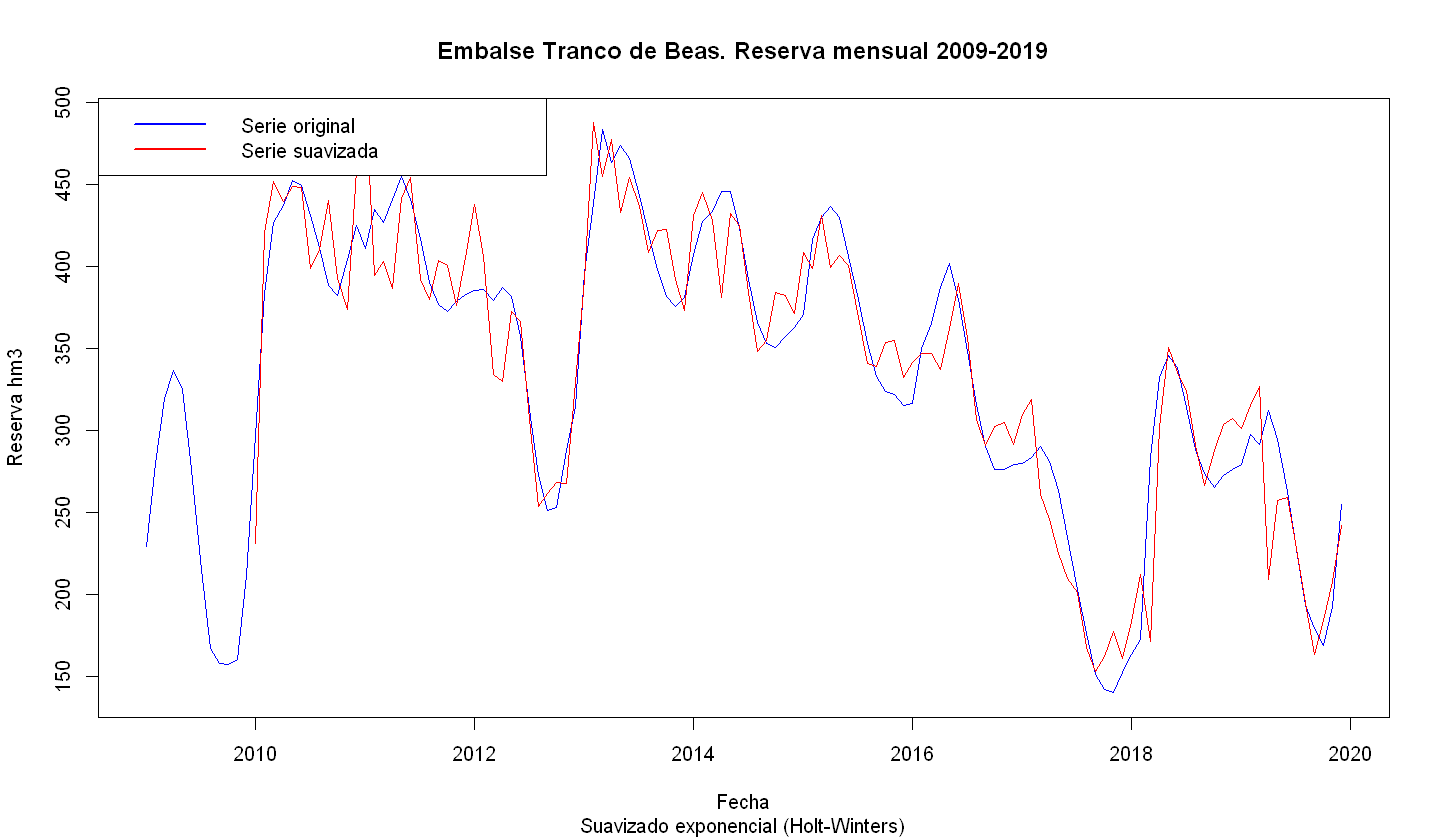

In [37]:
# Grafica serie inicial vs serie suavizada
plot(rests,
     xlab = "Fecha",
     ylab = "Reserva hm3",
     ylim = c(0.99*min(rests), 1.01*max(rests)),
     col = 'blue')
lines(rests.hw$fitted[,1], col="red")
legend("topleft",
       legend=c("Serie original ","Serie suavizada"),
       col=c("blue","red"),lwd=2)
title(main = 'Embalse Tranco de Beas. Reserva mensual 2009-2019',
      sub = 'Suavizado exponencial (Holt-Winters)')

fit,326.8372,430.537,539.2427,590.2151,573.1296,538.3199,500.5026,464.114,435.6257,423.5679,458.3153,520.3624


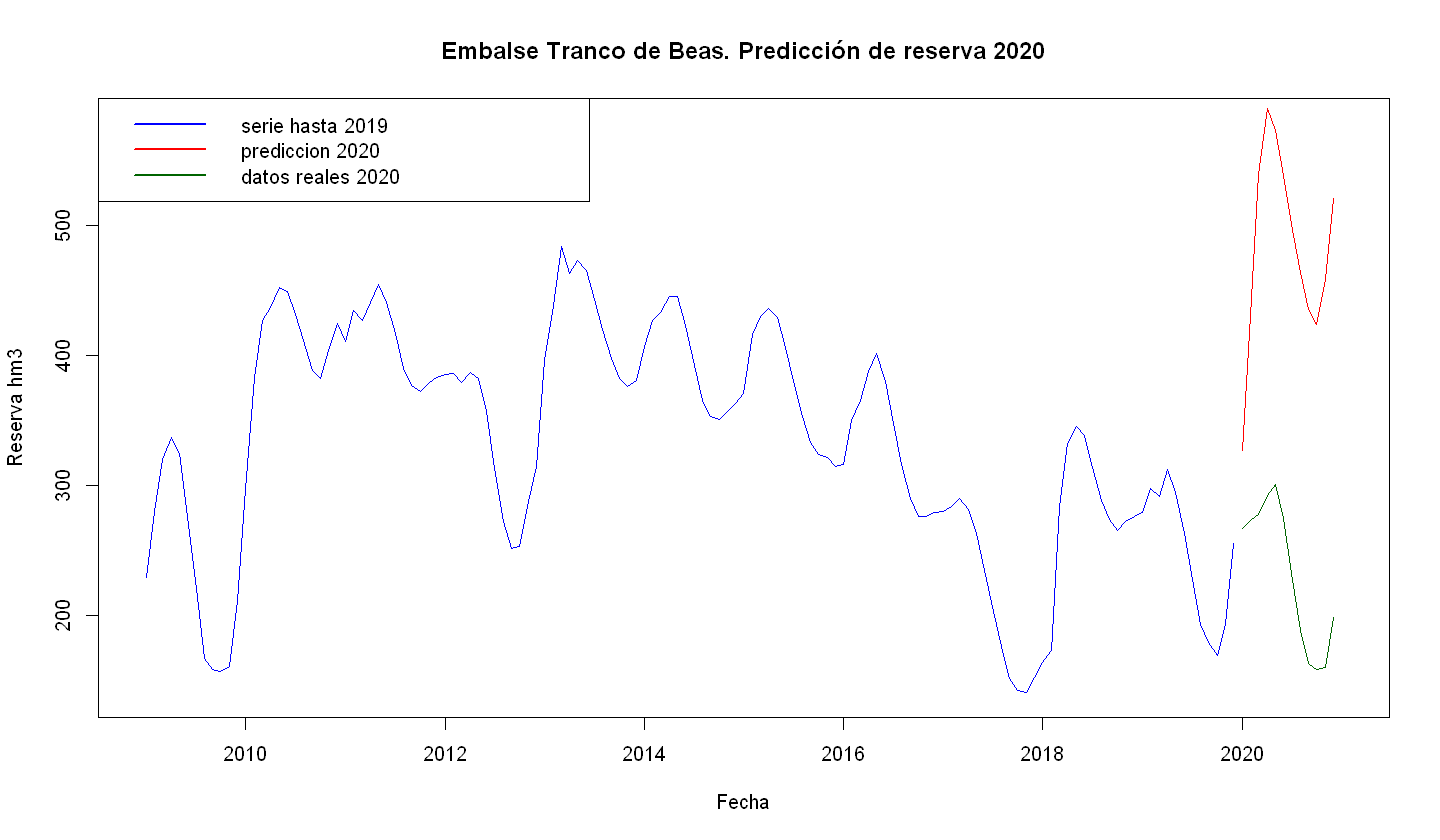

In [39]:
#predicción para 2020
rests.pred2020 <- predict(rests.hw, n.ahead=12)
t(as.data.frame(rests.pred2020))

plot(rests,
     xlim = c(2009, 2021),
     ylim = c(0.99*min(rests), 1.20*max(rests)),
     main = "Embalse Tranco de Beas. Predicción de reserva 2020",
     xlab = "Fecha",
     ylab = "Reserva hm3",
     col = 'blue')
lines(rests.pred2020, col = 'red')
lines(rests.check, col = 'dark green')
legend("topleft",
       legend=c("serie hasta 2019","prediccion 2020",'datos reales 2020'),
       col=c("blue","red",'dark green'),lwd=2)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



         Point Forecast       Lo 80     Hi 80      Lo 95     Hi 95
Jan 2020       326.8372  287.986570  365.6879  267.42028  386.2542
Feb 2020       430.5370  356.037032  505.0371  316.59911  544.4750
Mar 2020       539.2427  418.237581  660.2477  354.18136  724.3040
Apr 2020       590.2151  414.699450  765.7307  321.78708  858.6431
May 2020       573.1296  336.357078  809.9022  211.01727  935.2420
Jun 2020       538.3199  234.298329  842.3416   73.35901 1003.2809
Jul 2020       500.5026  123.766784  877.2385  -75.66513 1076.6704
Aug 2020       464.1140    9.598952  918.6291 -231.00680 1159.2349
Sep 2020       435.6257 -101.414098  972.6655 -385.70580 1256.9572
Oct 2020       423.5679 -200.478388 1047.6141 -530.82852 1377.9642
Nov 2020       458.3153 -256.996019 1173.6266 -635.65896 1552.2896
Dec 2020       520.3624 -290.280531 1331.0053 -719.40897 1760.1337

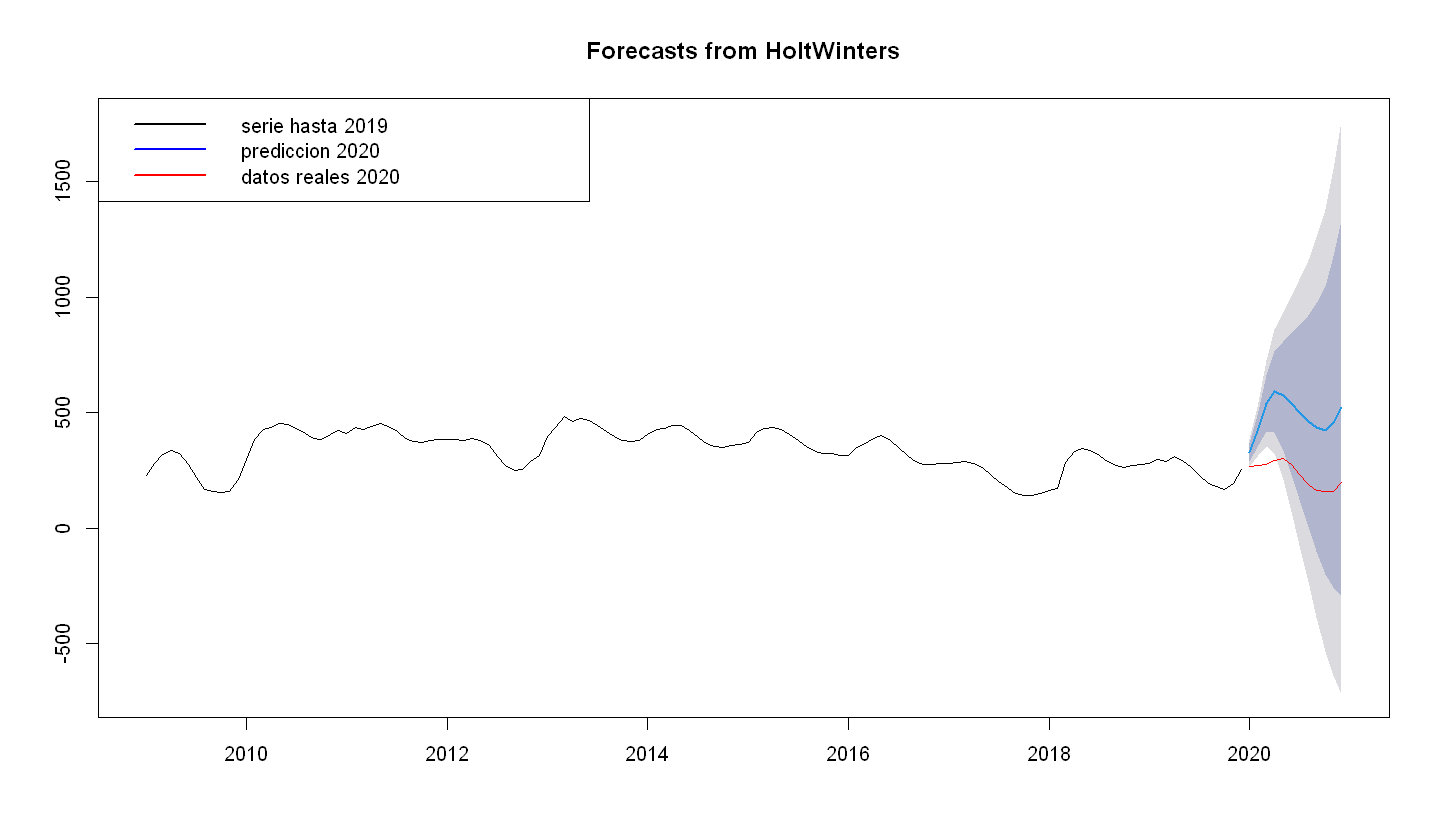

In [28]:
# con la libreria forecast
library(forecast)
(rests.pred2020b <- forecast(rests.hw, h=12))
plot(rests.pred2020b)
lines(rests.check, col = 'red')
legend("topleft",
       legend=c("serie hasta 2019","prediccion 2020",'datos reales 2020'),
       col=c("black","blue",'red'),lwd=2)


Como se observa las predicciones, aunque captan algo del comportamiento histórico de la serie, difieren de forma relevante respecto de los valores reales.

Por tanto, para este modelo no se adapta de forma efectiva a la serie de datos que tratamos de analizar.

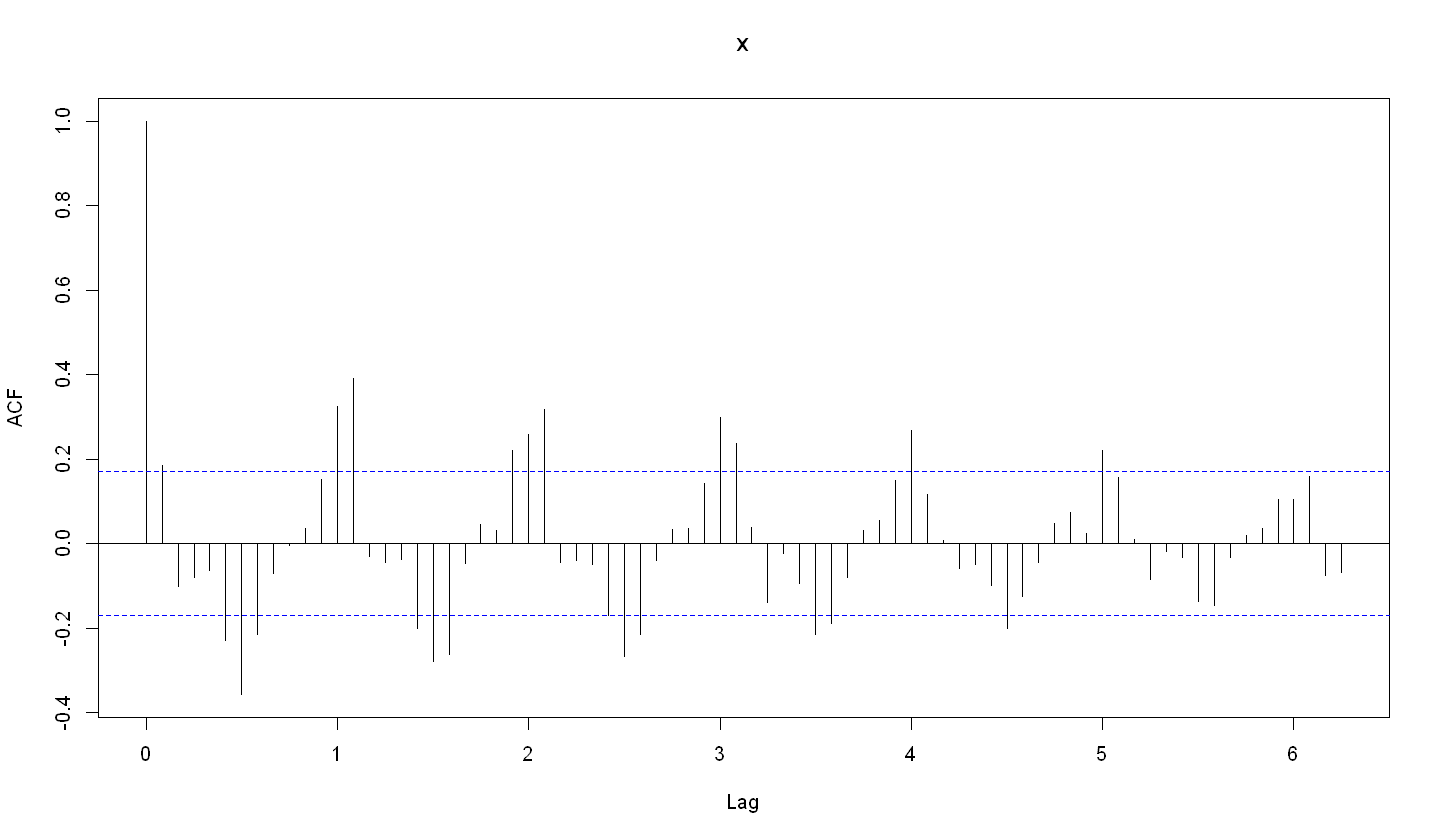

In [40]:
#Función de autocorrelación de los residuos de las predicciones
acf(rests.pred2020b$residuals, na.action = na.pass, lag.max=75)

Se observa que la autocorrelación disminuye progresivamente y, aunque con oscilaciones, parecen converger a cero. No  obstante esta lentitud en la convergencia es un indicio de que las predicciones pueden ser mejoradas con otros modelos.

A continuación se indican varios índices para la medida del error cometido en la predicción. Todos estos indices apuntan a que las predicciones no son muy buenas. En concreto el [Indice U de Teil](https://www.economicsnetwork.ac.uk/showcase/cook_theil) supera con creces el valor 1 que es indicativo de una desigualdad noteble entre la serie original y la predicción.

In [41]:
#Error en la predicción de 2020

errors <- data.frame(t(accuracy(rests.pred2020b$mean , rests.check)))

errors$description <- c('Error medio', 
                        'Raíz del error cuadrático medio',
                        'Error medio absoluto',
                        'Porcentaje de error medio',
                        'Porcentaje de error medio absoluto',
                        'Autocorrelación de errores con retraso 1',
                        'Índice U de desigualdad de Theils')
errors

,Test.set,description
,<dbl>,<chr>
ME,-251.4699611,Error medio
RMSE,260.7298225,Raíz del error cuadrático medio
MAE,251.4699611,Error medio absoluto
MPE,-117.5450097,Porcentaje de error medio
MAPE,117.5450097,Porcentaje de error medio absoluto
ACF1,0.4218031,Autocorrelación de errores con retraso 1
Theil's U,11.2692416,Índice U de desigualdad de Theils


# 3 - Análisis mediante un modelo ARIMA

## 3.1 - Determinar si es estacionaria o necesita alguna transformación previa.

Anteriormente en el análisis básico de la serie hemos visto que la serie no era estacionaria. Pero vamos a aplicar el test de la raíz unitaria o [Test Dickey-Fuller aumentado](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) para confirmarlo.

In [46]:
library(tseries)
adf.test(rests)


	Augmented Dickey-Fuller Test

data:  rests
Dickey-Fuller = -3.0717, Lag order = 5, p-value = 0.1309
alternative hypothesis: stationary


p-valor > 0.05. Por tanto se desecha la hipoótesis alternativa, que considera que la serie es estacionaria. Por tanto se confirma nuestra primera suposición.

In [47]:
# Vemos si se cumple la condición de homocestaticidad. (Constancia de la varianza)
lambda <- BoxCox.lambda(rests, lower = 0, upper = 2)
lambda

[1] 1.82429

El  valor de lambda es mayor que 1 por tanto es necesario aplicar la [Transformación de Box-Cox](https://en.wikipedia.org/wiki/Power_transform)

In [48]:
# Aplicamos la transformación de Box-Cox
rests.BC <- BoxCox(rests, lambda)
rests.BC
BoxCox.lambda(rests.BC, lower = 0, upper = 2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2009,11087.992,15919.002,20303.777,22323.205,20912.923,15533.558,10339.853,6211.681,5604.627,5552.785,5759.212,9571.186
2010,17721.888,28287.088,34435.415,35918.871,38306.533,37855.098,35086.601,32197.653,28969.622,28176.168,31166.901,34147.399
2011,32159.101,35610.352,34451.612,36474.514,38630.023,36509.275,33017.835,29241.164,27457.418,26846.492,27649.105,28230.471
2012,28555.662,28627.403,27749.181,28800.999,28109.462,24860.140,19532.409,15185.993,13070.863,13281.659,16777.937,19740.298
2013,30057.113,36127.726,43243.378,39983.499,41614.244,40365.483,36857.708,33449.580,30292.897,28109.462,27294.162,27988.688
2014,31603.154,34466.339,35411.802,37265.594,37213.735,33895.551,29505.612,25953.427,24378.129,24027.867,24848.705,25607.238
2015,26593.119,32922.557,34870.968,35860.370,34832.481,31446.127,27858.784,24337.839,21849.711,20820.428,20558.454,19764.349
2016,19927.328,23989.090,25900.329,28836.318,30834.157,27830.696,23720.935,19877.911,17036.288,15546.917,15547.945,15849.469
2017,15944.922,16307.533,17009.516,16070.947,14244.606,11549.893,8890.542,6826.704,5182.302,4634.825,4515.943,5253.854
2018,5976.283,6591.167,16293.881,21814.960,23433.105,22509.854,19643.083,16836.497,15315.403,14425.934,15153.464,15548.973


[1] 1.004235

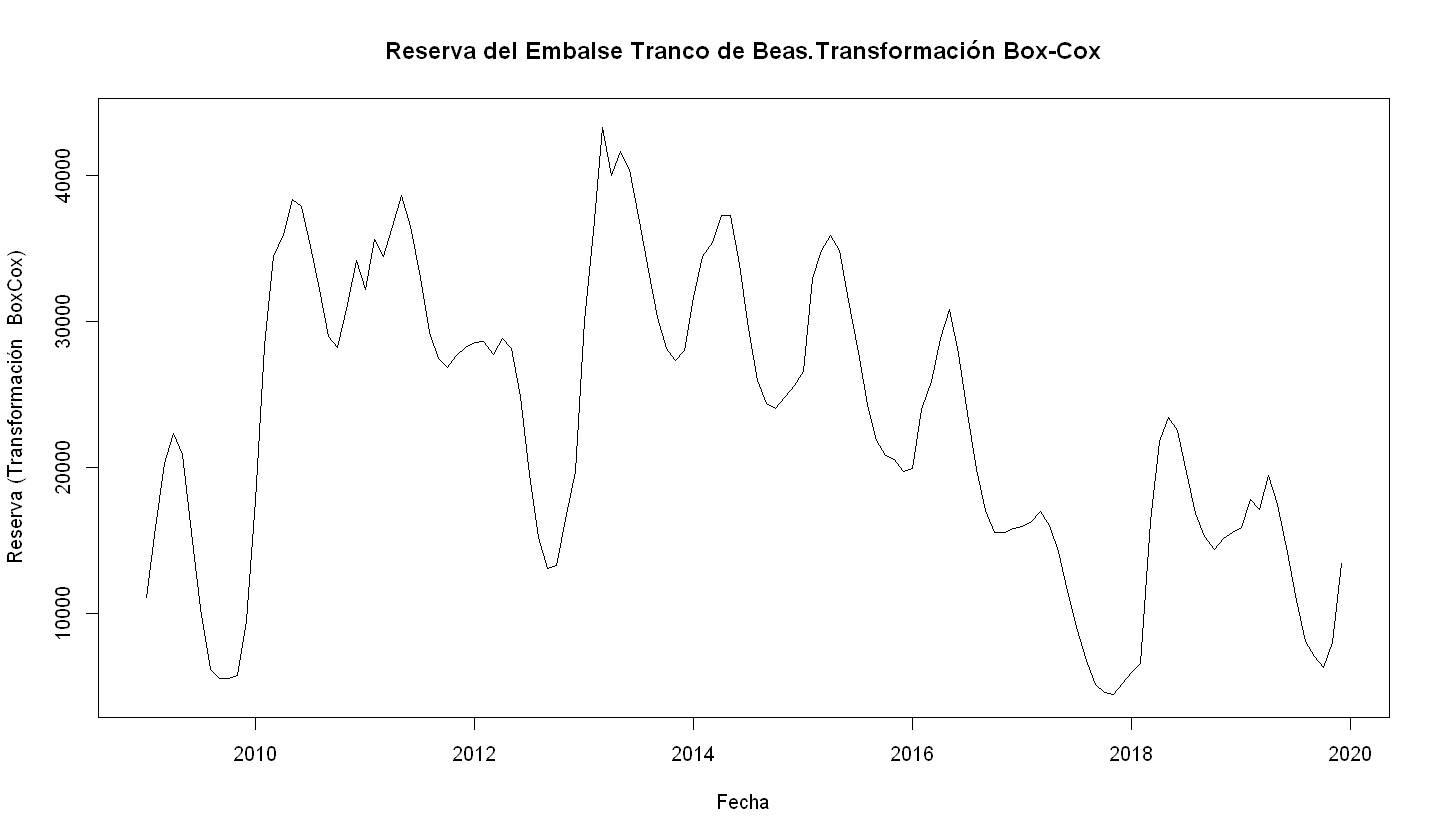

In [49]:
plot(rests.BC,
     main = "Reserva del Embalse Tranco de Beas.Transformación Box-Cox",
     xlab = "Fecha",
     ylab = "Reserva (Transformación  BoxCox)",
     ylim = c(0.99*min(rests.BC), 1.01*max(rests.BC)))

## 3.2 - Contrastar si la serie transformada puede considerarse estacionaria.

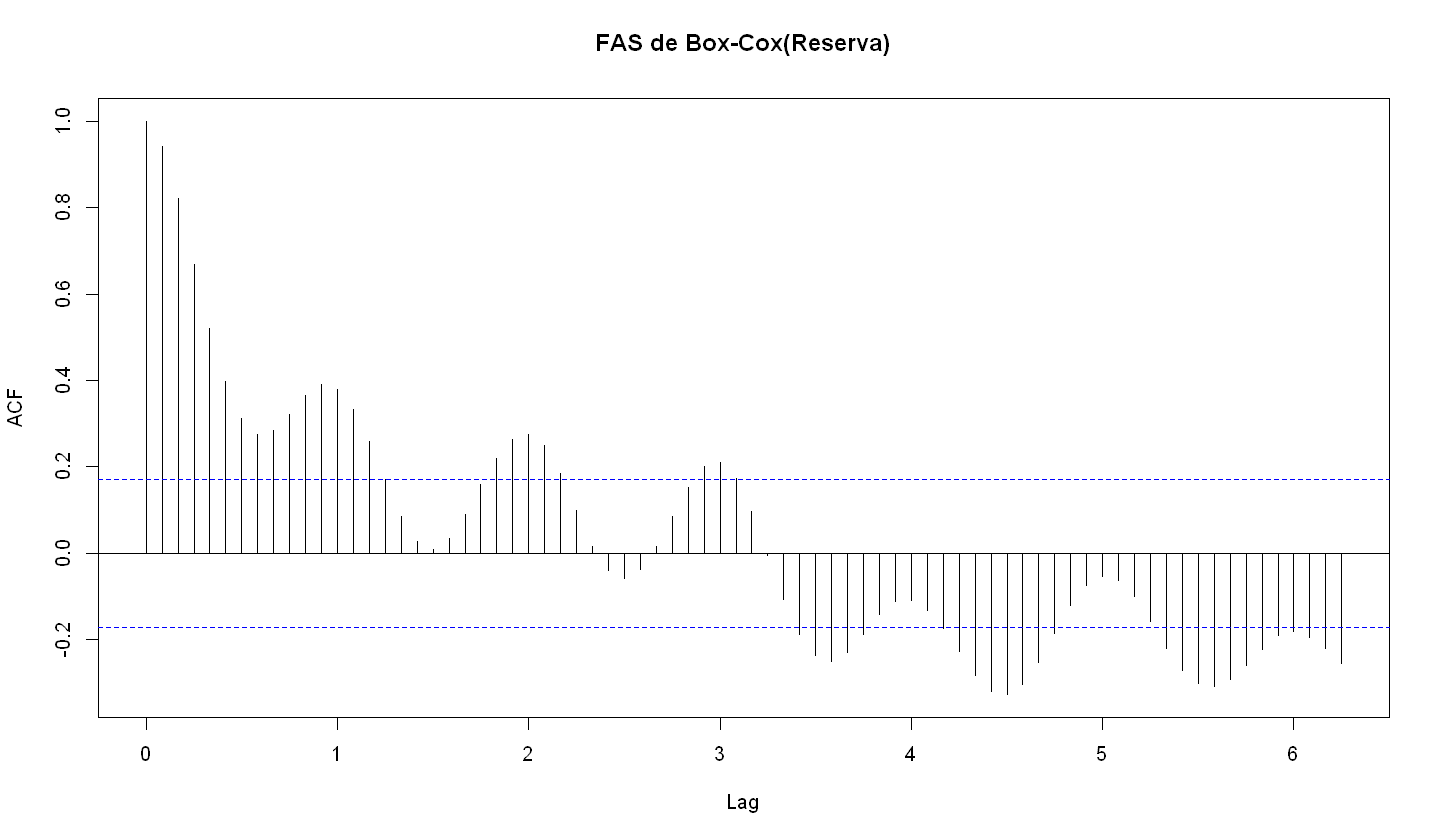

In [50]:
# Estacionariedad en medias
acf(rests.BC, main = "FAS de Box-Cox(Reserva)", lag.max =75)

In [51]:
#Probamos el test de raíz unitaria con los datos transformados
adf.test(rests.BC)


	Augmented Dickey-Fuller Test

data:  rests.BC
Dickey-Fuller = -3.2374, Lag order = 5, p-value = 0.08474
alternative hypothesis: stationary


Se observa que la serie sigue sin ser estacionaria.(p-vlue > 0.05)

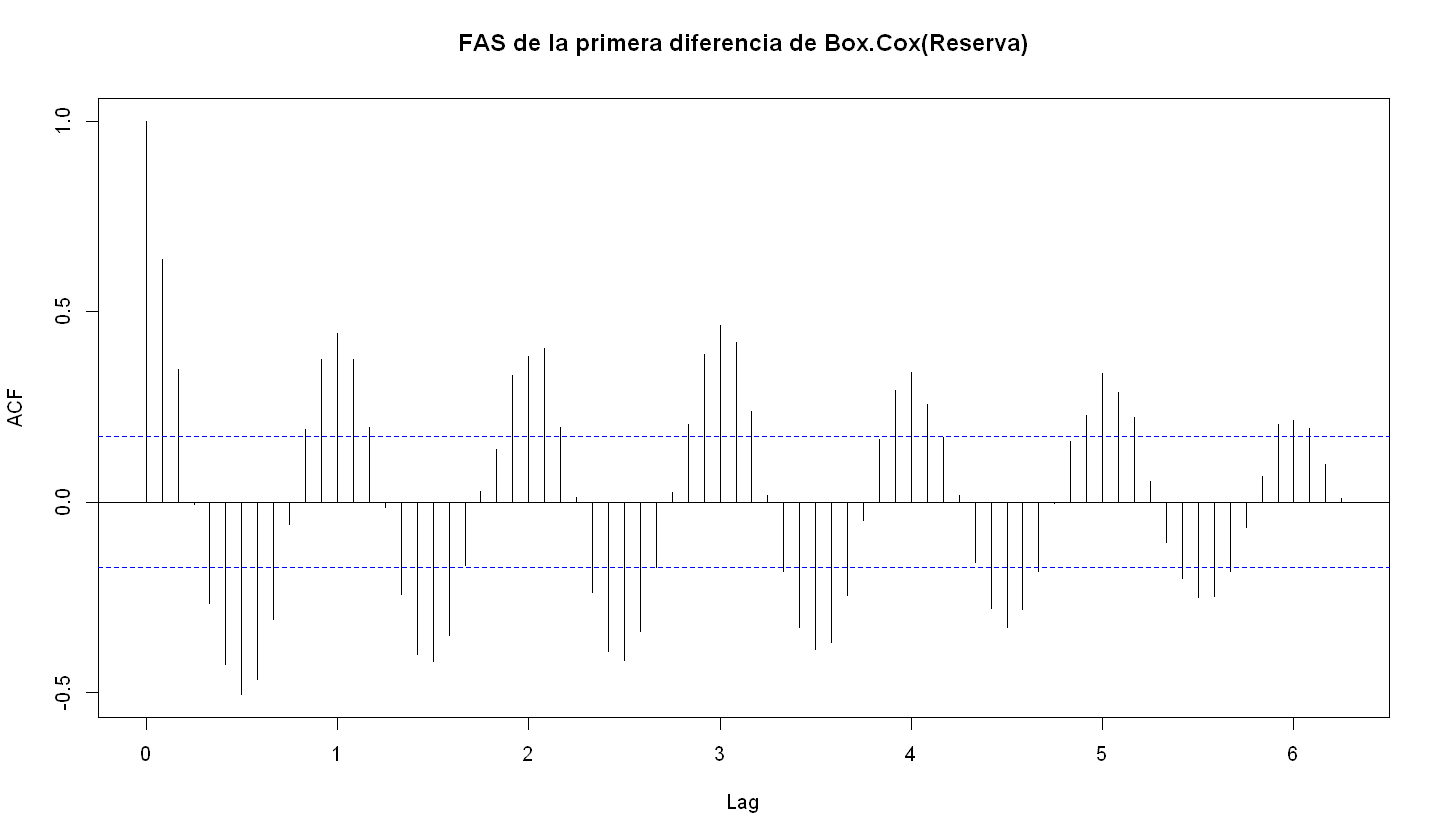

In [52]:
# Probamos con la diferenciación de primer orden
rests.d1 <- diff(rests.BC, lag = 1, differences = 1)
acf(rests.d1, main="FAS de la primera diferencia de Box.Cox(Reserva)", lag.max = 75)

Hemos visto anteriormente que la serie tiene estacionalidad cosa que queda clara en la autocorrelación estacional que muestra la serie.Por tanto este efecto tenemos eliminarlo de la serie de diferencias de orden 1

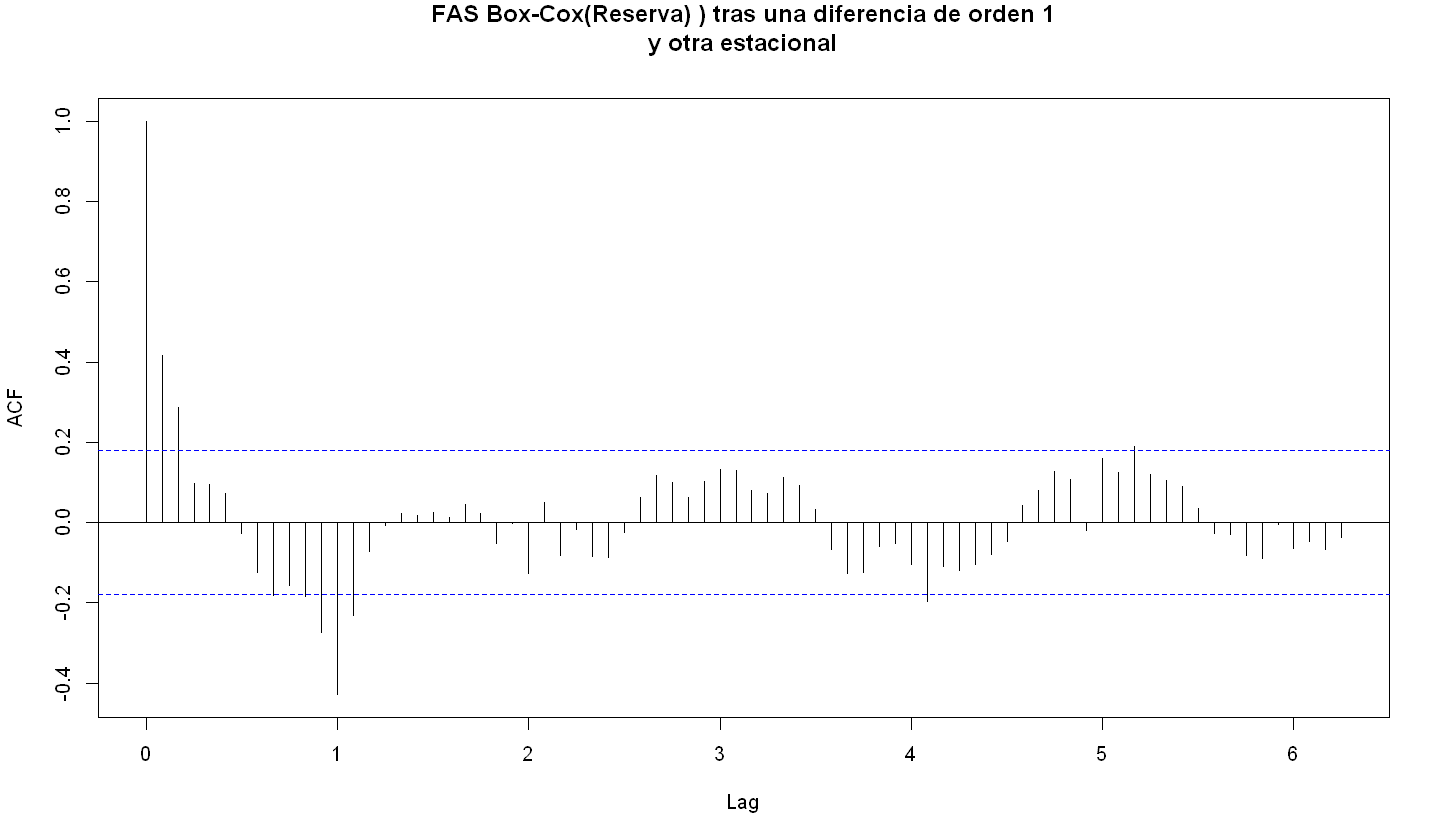

In [53]:
rests.d12 <- diff(rests.d1, lag = 12, differences = 1)
acf(rests.d12, main = "FAS Box-Cox(Reserva) ) tras una diferencia de orden 1
y otra estacional", lag.max = 75)

Con esto hemos disminuido gran parte de las autocorrelaciones al intervalo (-0.2, 0.2). Podemos considerar por tanto que la serie no está autocorrelada

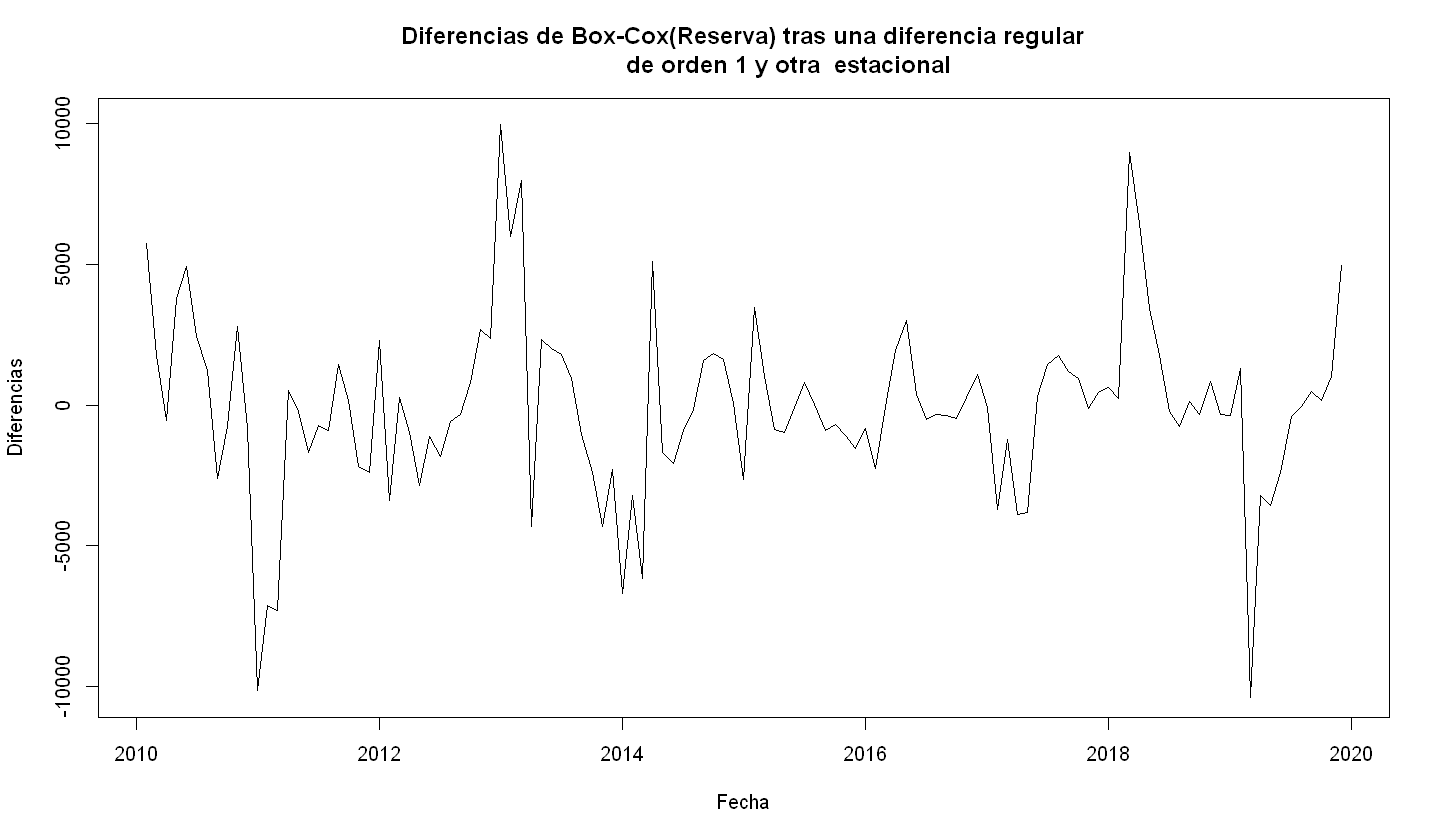

In [54]:
plot(rests.d12,
     main = "Diferencias de Box-Cox(Reserva) tras una diferencia regular
             de orden 1 y otra  estacional",
     xlab = "Fecha",
     ylab = "Diferencias",
     ylim = c(0.99*min(rests.d12), 1.01*max(rests.d12)))

In [63]:
#Probamos el test de raíz unitaria
adf.test(rests.d12)



	Augmented Dickey-Fuller Test

data:  rests.d12
Dickey-Fuller = -3.8801, Lag order = 4, p-value = 0.01748
alternative hypothesis: stationary


En sentido estricto, dado que p-valor > 0.01 la serie no es estacionaria. No obstante, siendo un valor de referencias, es un valor arbitrario. Al ser el p-valor ligeramente mayor que 0.01 que se acepta que la serie es estacionaria. No obstante hay que tener presente que es posible que está aproximación puede disminuir la efeciencia de los modelos de predicción que se van a aplicar a continuación.

## 3.3 - Estructura ARMA y ARIMA datos de los transformados

Aplicamos el metodo sample extended acf, para ver las mejores opciones para los modelos.

In [56]:
# Estructura del modelo ARMA
library(TSA)

Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast


Attaching package: 'TSA'


The following objects are masked from 'package:stats':

    acf, arima


The following object is masked from 'package:utils':

    tar




In [161]:
eacf(rests.d12)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x o o o o o o o o x  x  x  o 
1 x x x o o o o o o o o  x  o  o 
2 x o o o o o o o o o o  x  o  o 
3 x o o o o o o o o o o  x  o  o 
4 x x o o o o o o o o o  x  o  o 
5 x x x o o o o o o o o  x  x  o 
6 x o o x o o o o o o o  x  o  o 
7 x o o x o o o o o o o  x  o  o 


El resultado sugiere examinar los modelos MA(2), ARMA(2,1), ARMA(3,1), ARMA (2,2), ARMA(3,2) o ARMA(3,4). Para ver cual de estos modelos es el más edecuado vamos aplicar el criterio AIC.

In [92]:
fit1 <- arima(rests.d12, order = c(0,0,2))
fit2 <- arima(rests.d12, order = c(2,0,1))
fit3 <- arima(rests.d12, order = c(3,0,1))
fit4 <- arima(rests.d12, order = c(4,0,2))
fit5 <- arima(rests.d12, order = c(6,0,1))
fit6 <- arima(rests.d12, order = c(6,0,2))
fit7 <- arima(rests.d12, order = c(1,0,10))
fit8 <- arima(rests.d12, order = c(1,0,12))
fit9 <- arima(rests.d12, order = c(6,0,12))
fit10 <- arima(rests.d12, order = c(4,0,12))


c(fit1$aic, fit2$aic, fit3$aic, fit4$aic, fit5$aic, fit6$aic,fit7$aic,fit8$aic,fit9$aic,fit10$aic)

[1] 2232.268 2234.526 2236.324 2231.921 2227.535 2229.488 2233.870 2191.886
 [9] 2199.698 2196.056

Se ve que con el modelo ARIMA(1,0,12) es como se obtiene un menor AIC.

In [164]:
# Probamos con la función auto.arima.
auto.arima(rests.d12)

Series: rests.d12 
ARIMA(1,0,0)(2,0,1)[12] with zero mean 

Coefficients:
         ar1     sar1     sar2     sma1
      0.4404  -0.1303  -0.3088  -0.7999
s.e.  0.0872   0.1299   0.1198   0.1673

sigma^2 estimated as 4013187:  log likelihood=-1082.11
AIC=2174.22   AICc=2174.75   BIC=2188.12

Se comprueba que el modelo  AR(1) para diferencias de orden 1 junto con un modelo ARMA(2,1) para la estacionalidad ( lag =12) es el modelo que menor AIC proporciona.

## 3.4 - Diagnóstico del modelo final

Analizamos los residuos para detectar cualquier indicio de no aleatoriedad.

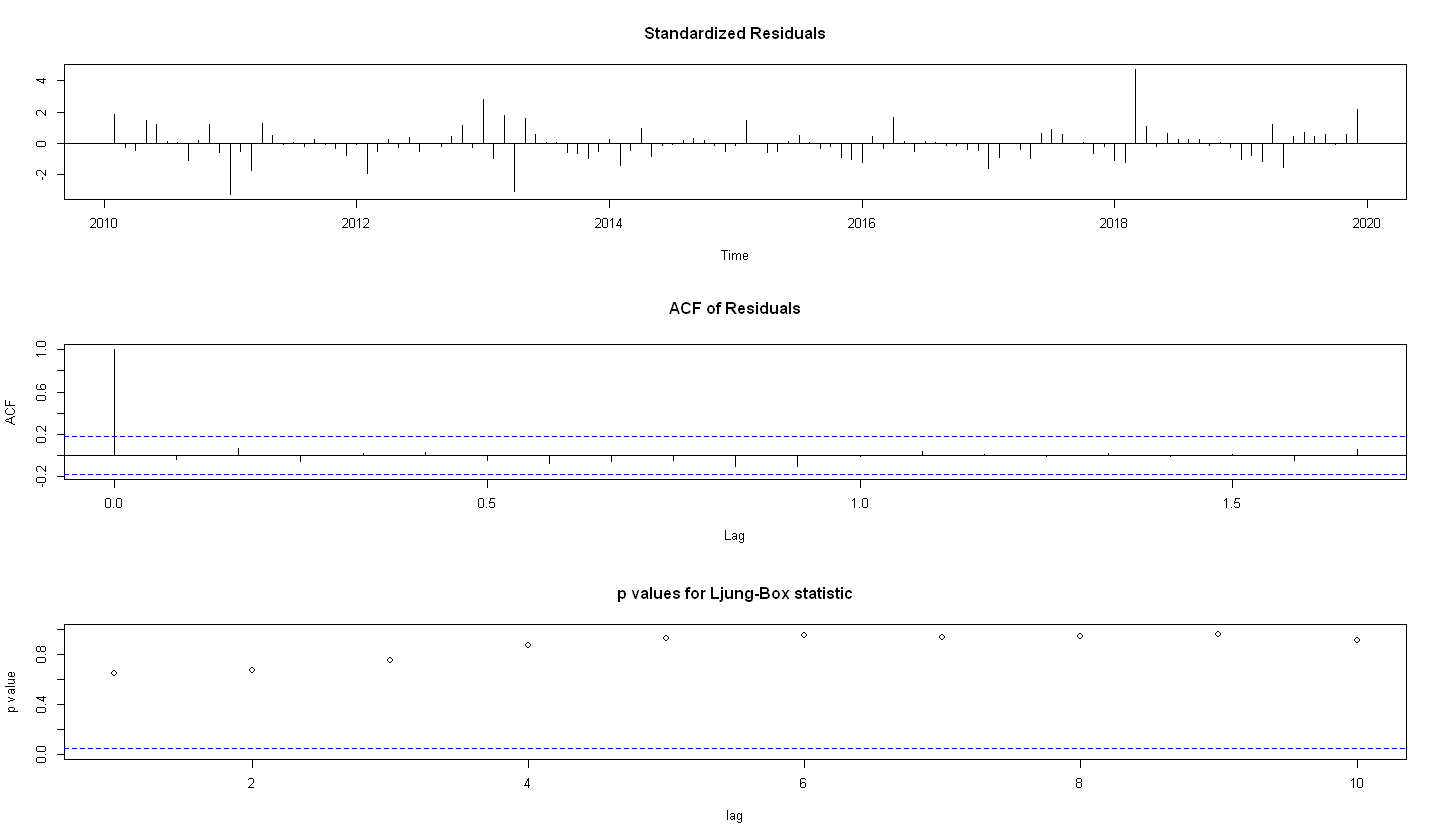

In [66]:
fit <- arima(rests.d12, order=c(1,0,0), seasonal = list(order = c(2, 0, 1), period = 12))
tsdiag(fit)

La función de autocorrelación se mantiene en el intervalo (-0.2,0.2) lo cual indica muy poca correlación entre los residuos. Por otro lado los p-valores del test Box-Ljung (H0: residuos independientes, H1: residuos dependientes), se mantienen con valores superiores a 0.05 por lo que adoptamos la hipótesis nula.

## 3.5 - Predicción de resultados

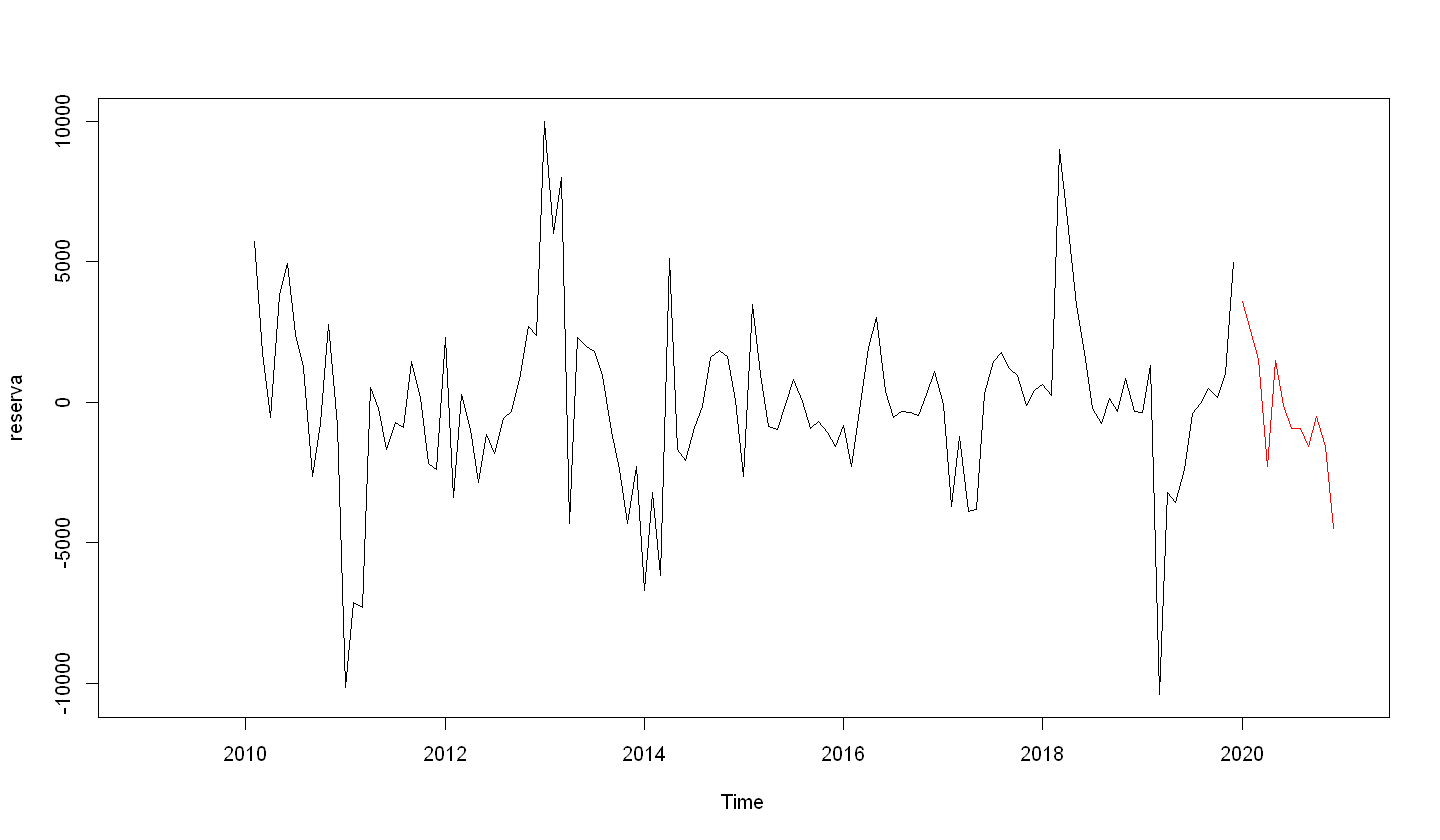

In [78]:
# Prediccíón de la serie de diferencias con el modelo ARIMA seleccionado
plot(rests.d12, xlim = c(2009,2021))
rests.d12_pred <-predict(fit, n.ahead = 12)
lines(rests.d12_pred$pred, col="red")

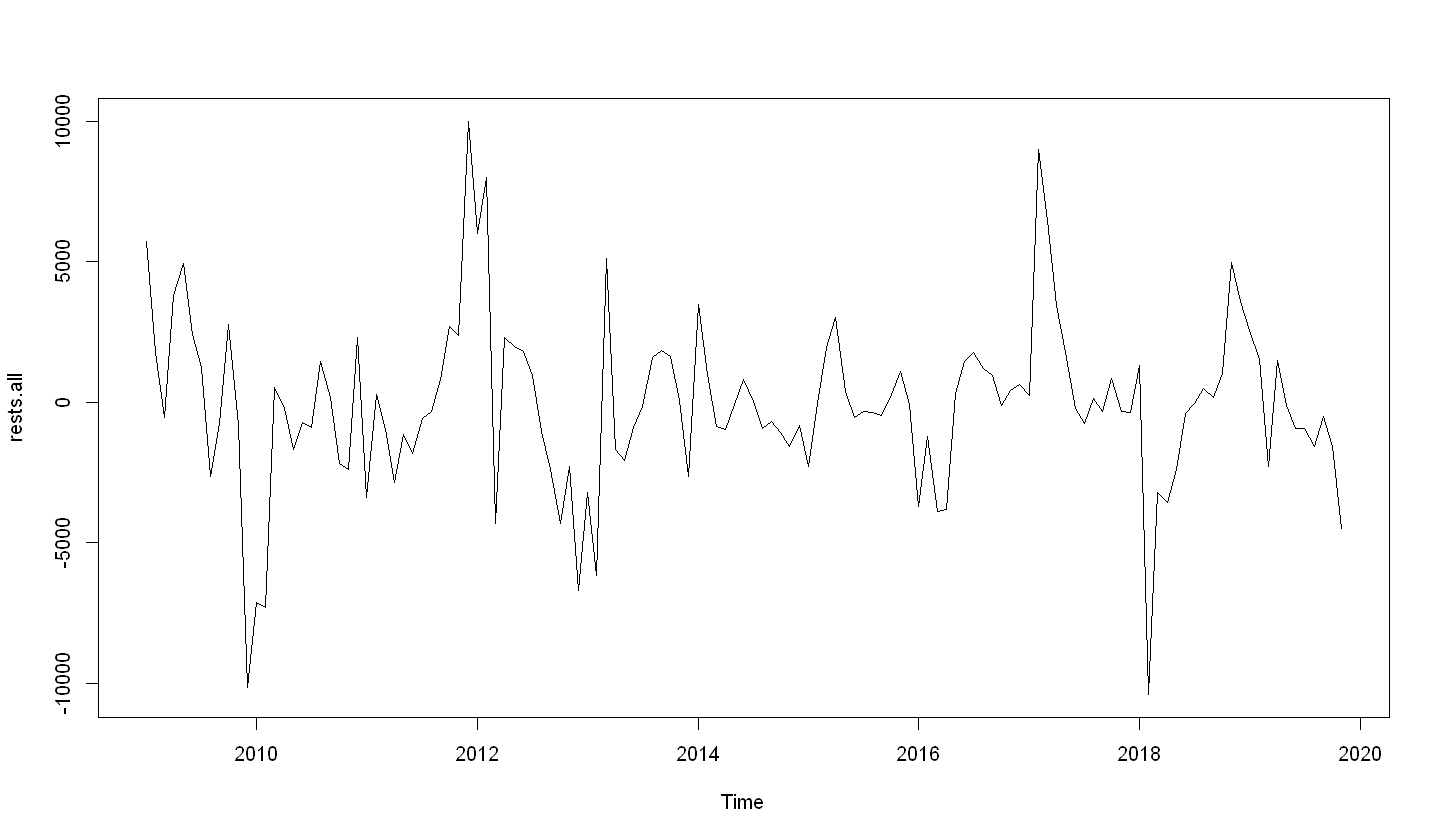

In [79]:
# Combinamos la serie temporal de differencias y la predicción
# en una misma serie

rests.all <- c(rests.d12, rests.d12_pred$pred)
rests.all <- ts(rests.all, start=c(2009,1),freq=12)
plot(rests.all, type="l")

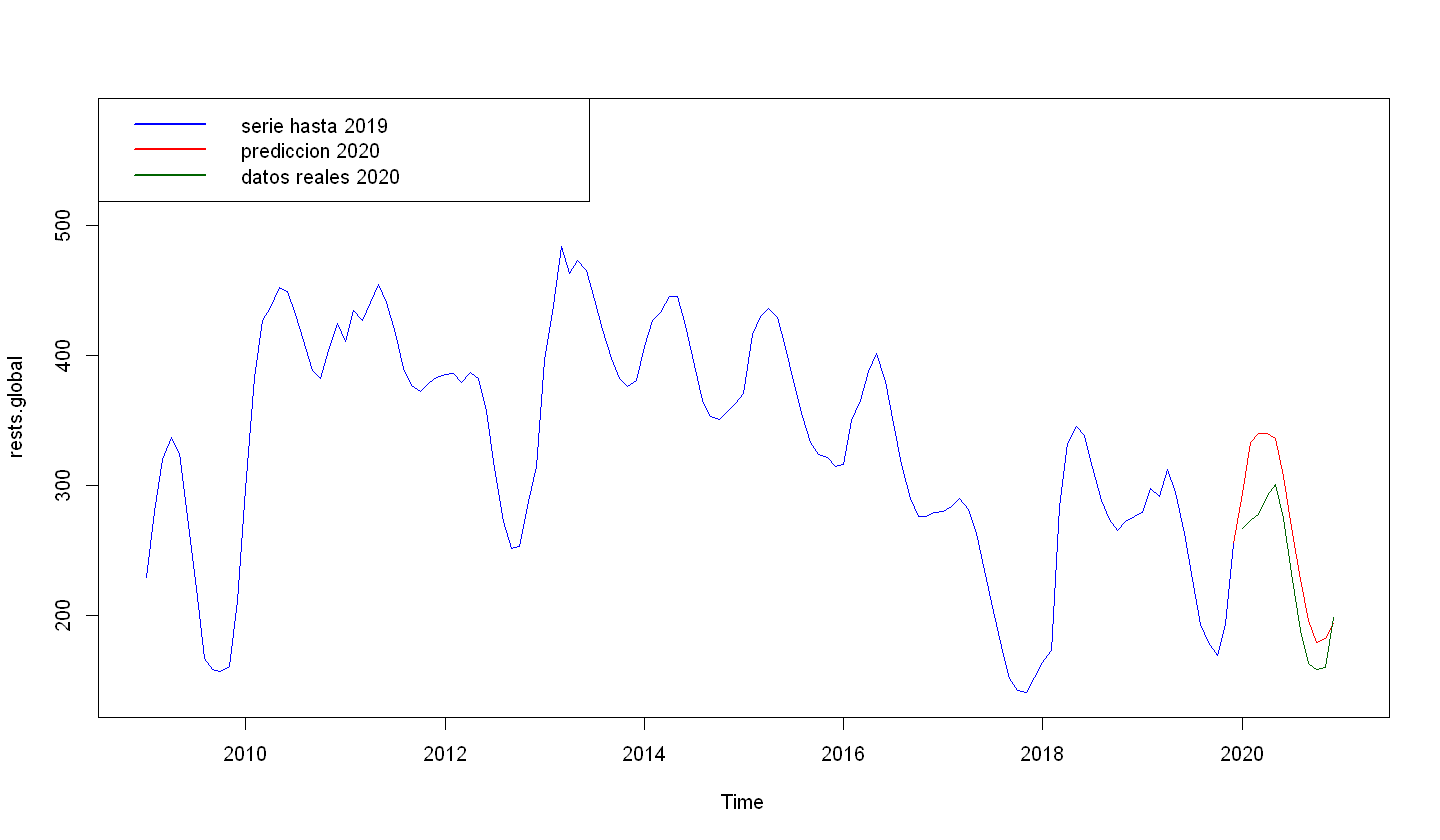

In [93]:
# Invertimos todas las transformaciones

# primero deshacemos la diferencia estacional
# xi es la lista de valores iniciales necesarios para invertir las diferencias.
# en este caso se toman el valor mensual del primer año con datos.
rests.inv1 <- diffinv(rests.all, lag = 12, differences = 1,
                     xi = c(rests.d1[1] ,rests.d1[2], rests.d1[3],
                            rests.d1[4], rests.d1[5], rests.d1[6],
                            rests.d1[7], rests.d1[8], rests.d1[9],
                            rests.d1[10], rests.d1[11], rests.d1[12]))

#segundo deshacemos la diferencia de orden 1
rests.inv2 <- diffinv(rests.inv1, lag = 1, differences = 1,
                     xi = rests.BC[1])

#y tercero la transformación Box-Cox
rests.inv3 <- InvBoxCox(rests.inv2,lambda)
rests.global <- ts(rests.inv3, start = 2009, freq = 12)

# hacemos un plot de las serie original con la predicción
plot(rests.global,
     type = "l",
     xlim = c(2009,2021),
     ylim = c(0.99*min(rests.global), 1.20*max(rests.global)),
     col = 'red')
lines(rests, col="blue")
lines(rests.check, col = 'dark green')
legend("topleft",
       legend=c("serie hasta 2019","prediccion 2020",'datos reales 2020'),
       col=c("blue","red",'dark green'),lwd=2)

Series: rests 
ARIMA(1,1,0)(2,1,1)[12] 

Coefficients:
         ar1     sar1     sar2     sma1
      0.4869  -0.1356  -0.2948  -0.7711
s.e.  0.0860   0.1489   0.1383   0.1775

sigma^2 estimated as 323:  log likelihood=-520.22
AIC=1050.44   AICc=1050.97   BIC=1064.34

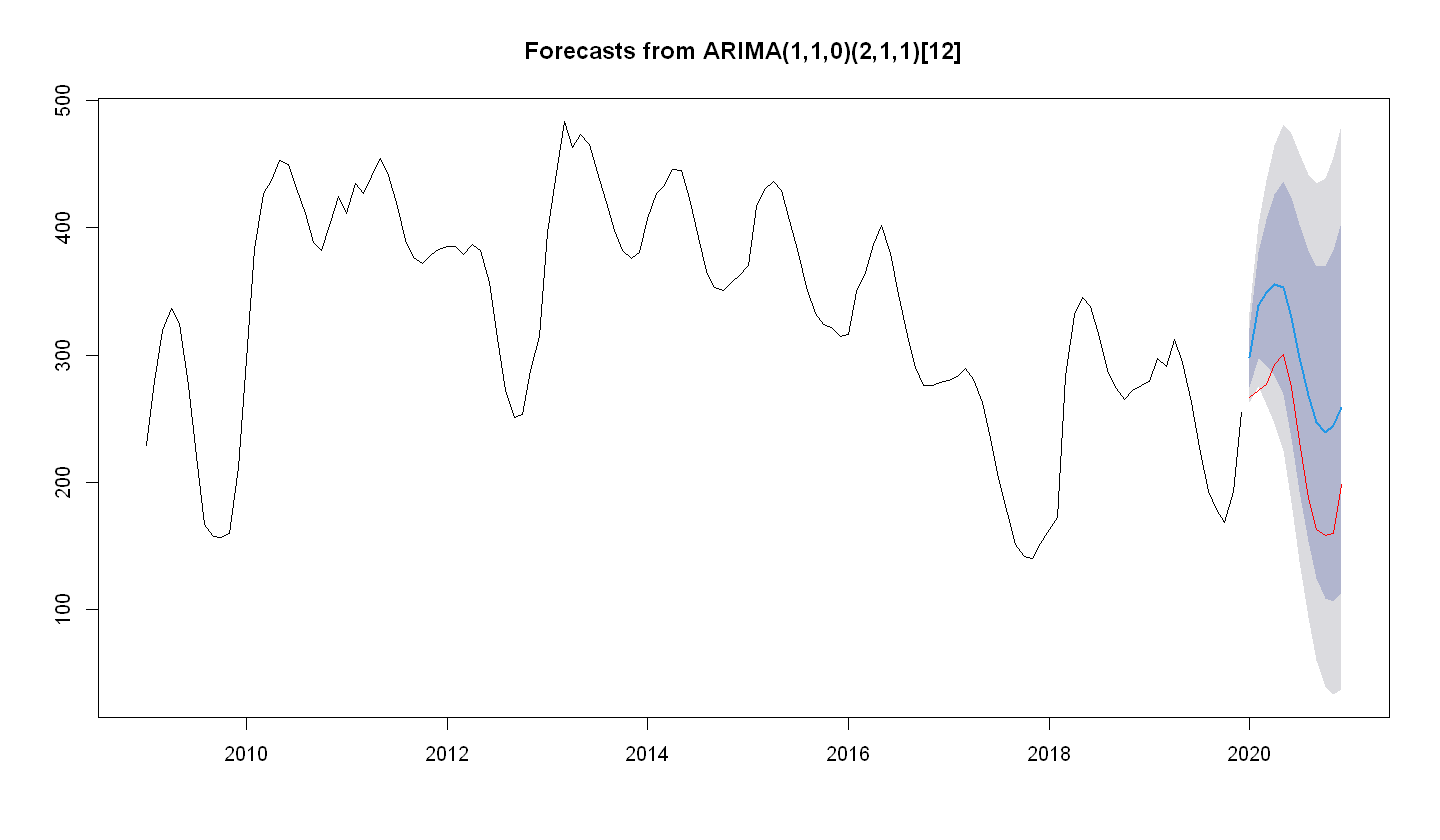

In [94]:
# Con la libreria forecast y la serie original (sin transformar)
ajuste <- auto.arima(rests)
ajuste
rests.fcast <- forecast(ajuste, h=12)
plot(rests.fcast)
lines(rests.check, col = 'red')

Se observa que con forecast la solución es prácticamente indentica, aunque de hecho el AIC obtenido es menor que el modelo obtenido haciendo todo el proceso paso a paso. Aunque para entender el mecanismo y los detalles es necesario hacer el proceso paso. Parece que en principio desde el punto de vista práctico es más recomendable usar forecast. No obstante en la seccion de cálculo de errores se verá cual proporciona mejor resultado

## 3.6 - Calculo de errores

In [95]:
# Errores con el modelo ARIMA paso a paso con transformaciones
(errors_steps <-  data.frame(t(accuracy(window(rests.global,2019), rests.check))))

,Test.set
,<dbl>
ME,-34.201673
RMSE,38.334508
MAE,34.978077
MPE,-14.604987
MAPE,14.996735
ACF1,0.447668
Theil's U,1.353393


In [96]:
# Errores con el modelo ARIMA obtenido a partir de la serie de partida
# y sin transformaciones previas
(errors_forecast <- data.frame(t(accuracy(rests.fcast$mean , rests.check))))

,Test.set
,<dbl>
ME,-66.3047496
RMSE,67.9836559
MAE,66.3047496
MPE,-31.5142673
MAPE,31.5142673
ACF1,0.3197843
Theil's U,2.9649770


# 4 Evaluación de los modelos

Se presentan en una misma tabla los errores calculados para los tres modelos (suavizado exponencia y los dos modelos ARIMA).

In [97]:
errores <- cbind(errors_steps, errors_forecast, errors)
errores <- errores[, c(4,1,2,3)]
colnames(errores)[2:4] <- c('arima_steps','arima_forecast','suav_exp')
errores

,description,arima_steps,arima_forecast,suav_exp
,<chr>,<dbl>,<dbl>,<dbl>
ME,Error medio,-34.201673,-66.3047496,-251.4699611
RMSE,Raíz del error cuadrático medio,38.334508,67.9836559,260.7298225
MAE,Error medio absoluto,34.978077,66.3047496,251.4699611
MPE,Porcentaje de error medio,-14.604987,-31.5142673,-117.5450097
MAPE,Porcentaje de error medio absoluto,14.996735,31.5142673,117.5450097
ACF1,Autocorrelación de errores con retraso 1,0.447668,0.3197843,0.4218031
Theil's U,Índice U de desigualdad de Theils,1.353393,2.9649770,11.2692416


Según se muestra en la tabla el modelo ARIMA(1,0,0)(2,0,1){12} proporciona los mejores índices de error de los tres modelos. No obstante se pone de manifiesto que los modelos ARIMA muestran mucha más precisión en que el modelo de suavizado exponencial. 